In [73]:
# %pip install seaborn
# %pip install xgboost
# %pip install catboost
# %pip install missingno
# %pip install scikit-learn==1.2.2
# %pip install rasterio pyproj rioxarray
# %pip install pykrige
# %pip install pyinterpolate

## Load In Dependencies

In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds
from rasterio.transform import from_origin

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score


# Evaluation Metrics
from sklearn.metrics import r2_score

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
from scipy.spatial import cKDTree
from pykrige.ok import OrdinaryKriging
import missingno as msno
import os
from tqdm import tqdm

## Response Variable

In [2]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("../Training_data_uhi_index_2025-02-18.csv")
ground_df

Longitude   Latitude          datetime  UHI Index
0     -73.909167  40.813107  24-07-2021 15:53   1.030289
1     -73.909187  40.813045  24-07-2021 15:53   1.030289
2     -73.909215  40.812978  24-07-2021 15:53   1.023798
3     -73.909242  40.812908  24-07-2021 15:53   1.023798
4     -73.909257  40.812845  24-07-2021 15:53   1.021634
...          ...        ...               ...        ...
11224 -73.957050  40.790333  24-07-2021 15:57   0.972470
11225 -73.957063  40.790308  24-07-2021 15:57   0.972470
11226 -73.957093  40.790270  24-07-2021 15:57   0.981124
11227 -73.957112  40.790253  24-07-2021 15:59   0.981245
11228 -73.957128  40.790237  24-07-2021 15:59   0.983408

[11229 rows x 4 columns]

## Predictor Variables

### Extracting GeoTIFF Image

#### Landsat8 bands

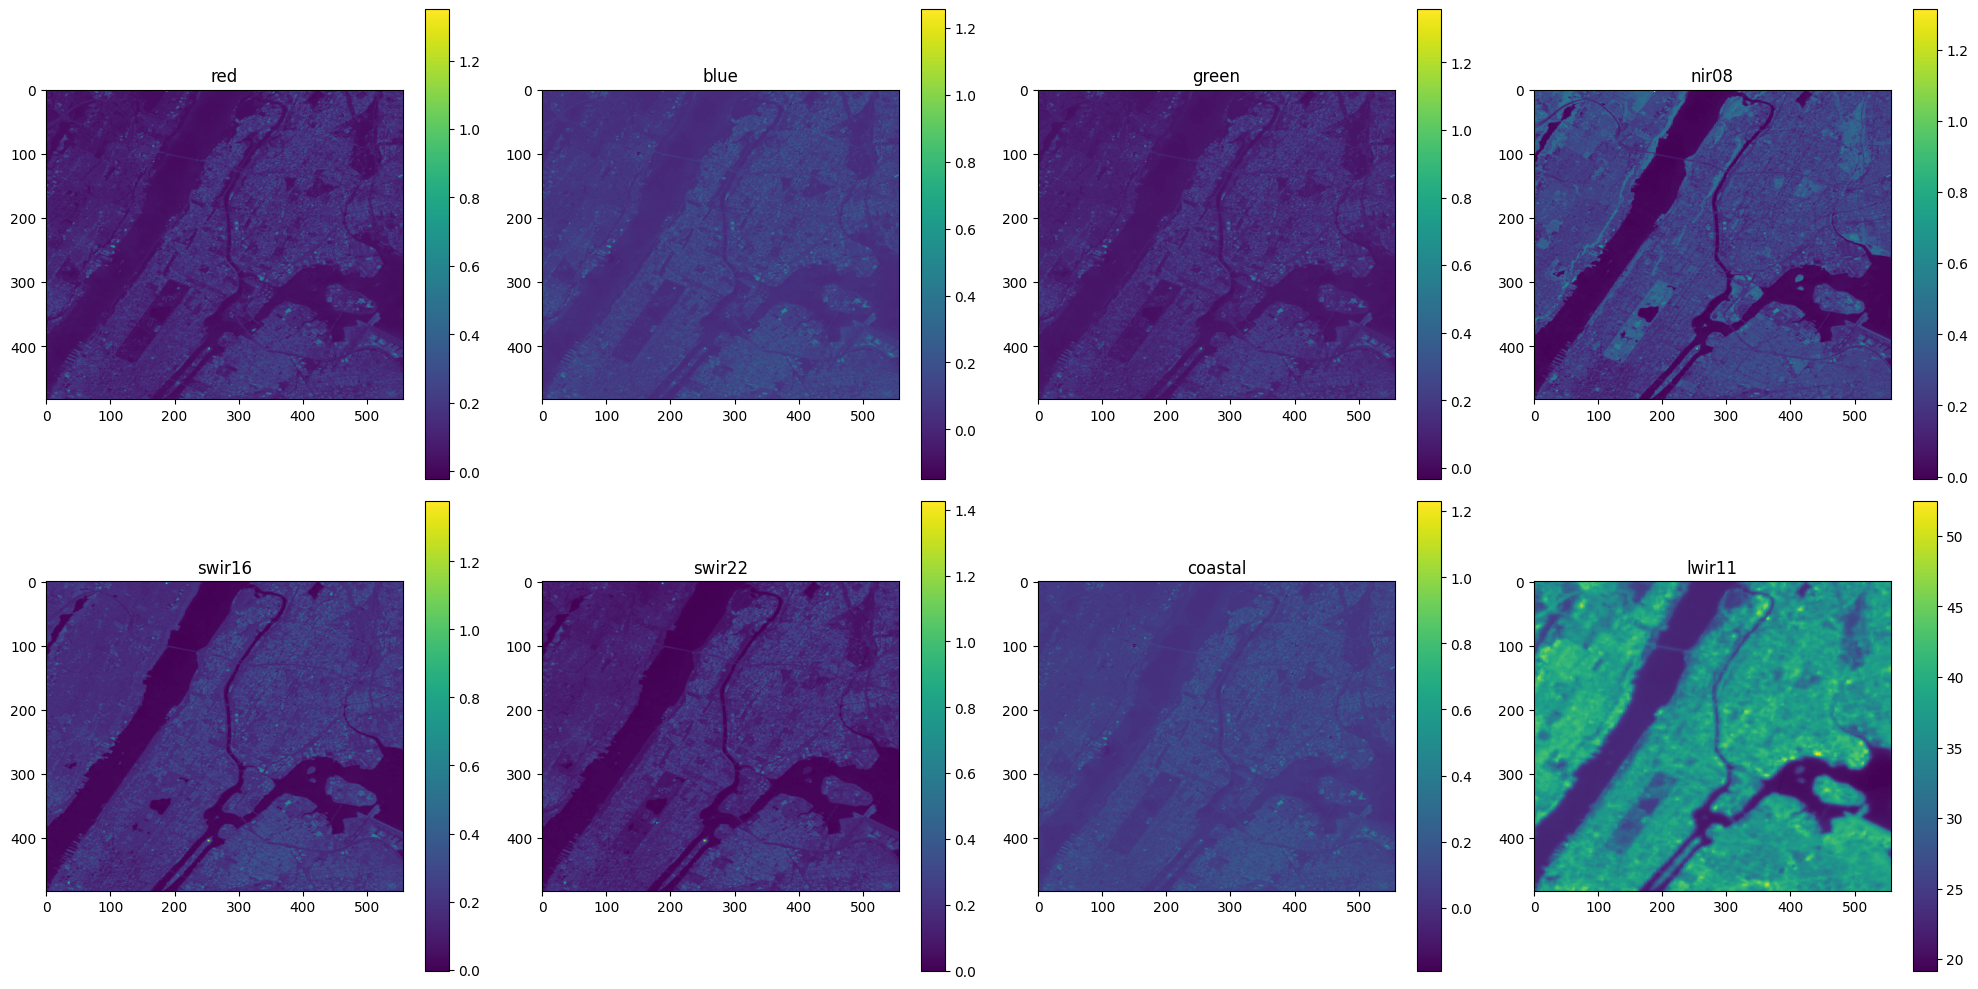

In [22]:
# Open the GeoTIFF file
tiff_path = "../data_pipeline/data/tiff/landsat_8.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as dst:
    red = dst.read(1)
    blue = dst.read(2)
    green = dst.read(3)
    nir08 = dst.read(4)
    swir16 = dst.read(5)
    swir22 = dst.read(6)
    coastal = dst.read(7) 
    lwir11 = dst.read(8)
    desc = dst.descriptions
    height = dst.height
    width = dst.width
    meta = dst.meta

band_name = desc 
band_lst = [red, blue, green, nir08, swir16, swir22, coastal, lwir11]
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes[i].imshow(band_lst[i], cmap='viridis')
    axes[i].set_title(band_name[i])
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()

In [23]:
desc

('red', 'blue', 'green', 'nir08', 'swir16', 'swir22', 'coastal', 'lwir11')

#### Building bands

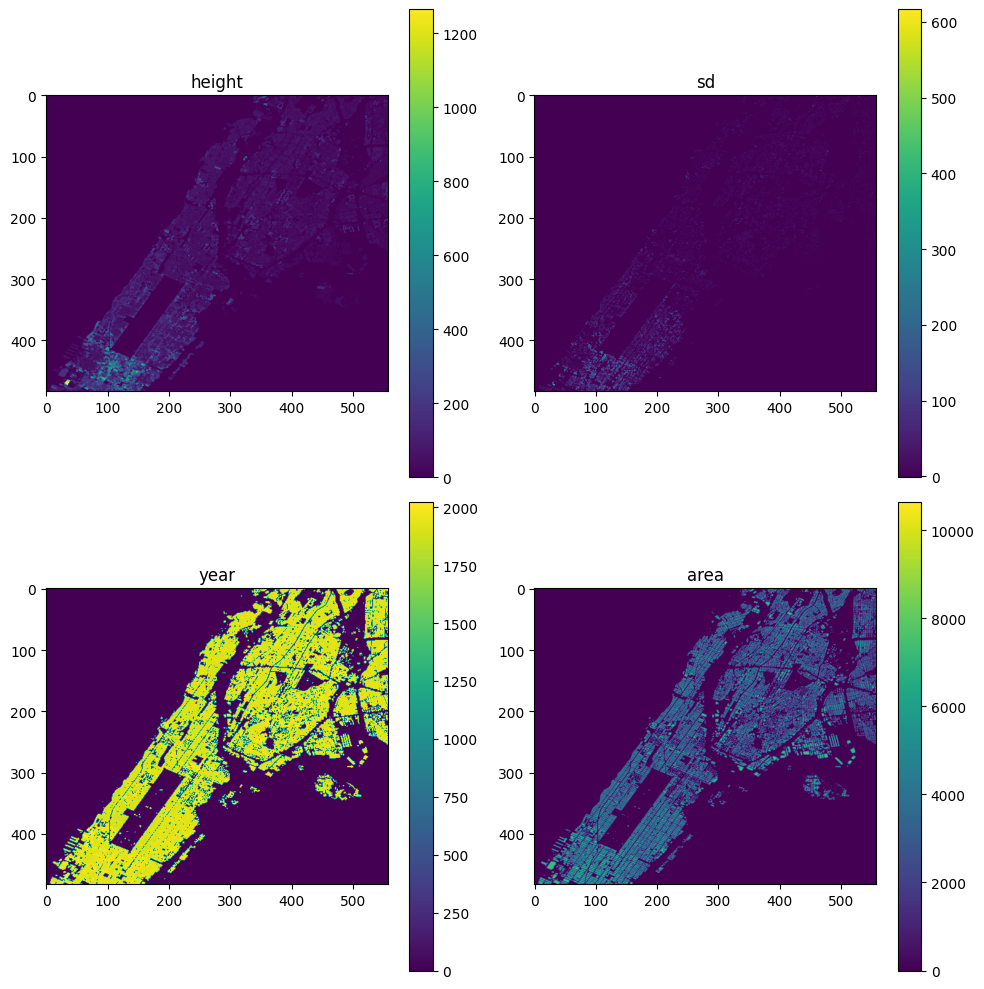

In [20]:
# Open the GeoTIFF file
tiff_path = "../data_pipeline/data/tiff/building_res30.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as dst:
    building_height = dst.read(1)
    building_sd = dst.read(2)
    building_year = dst.read(3)
    building_area = dst.read(4)
    desc = dst.descriptions

band_name = ['height', 'sd', 'year', 'area']
band_lst = [building_height, building_sd, building_year, building_area]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes[i].imshow(band_lst[i], cmap='viridis')
    axes[i].set_title(band_name[i])
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()


In [21]:
desc

('building_height_res30',
 'building_height_std_res30',
 'building_year_res30',
 'building_area_res30')

#### Street bands

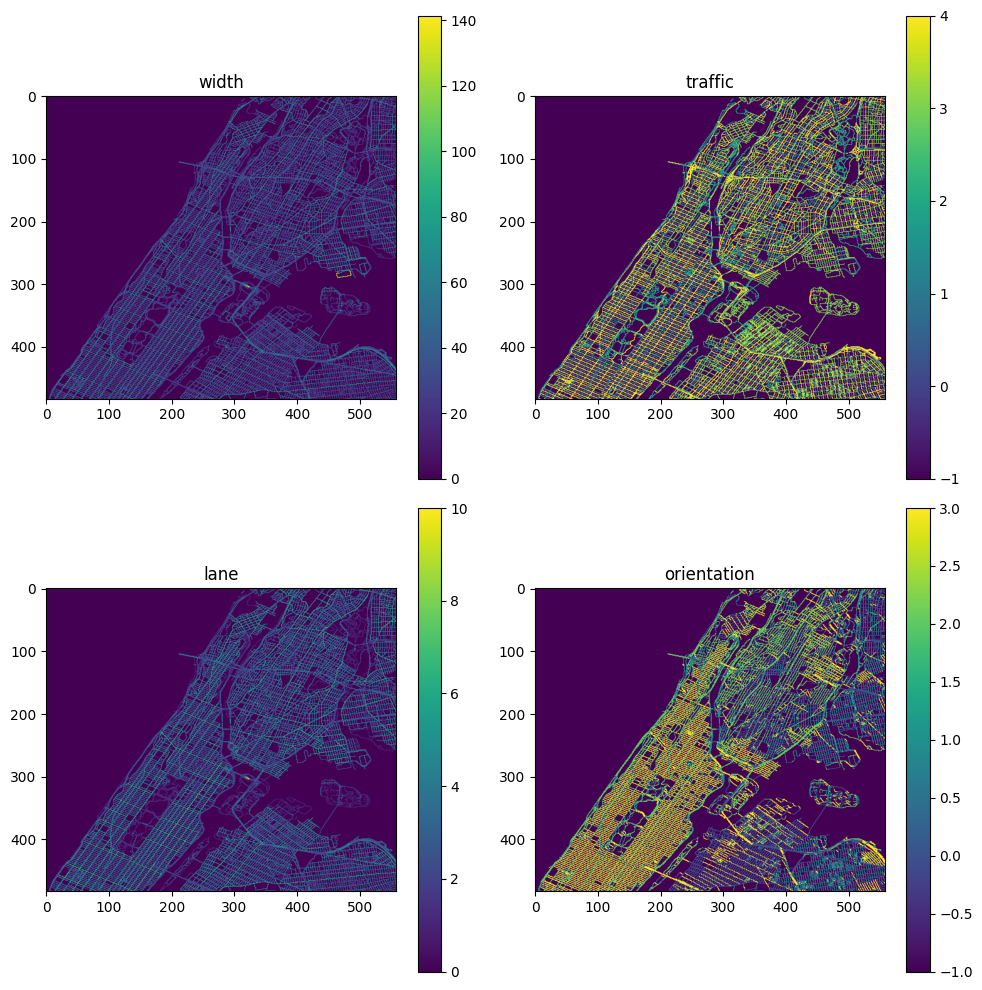

In [6]:
# Open the GeoTIFF file
tiff_path = "../data_pipeline/data/tiff/street/street_res30.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as dst:
    street_width = dst.read(1)
    traffic_dir = dst.read(2)
    street_lane = dst.read(3)
    orientation = dst.read(4)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

band_lst = [street_width, traffic_dir, street_lane, orientation]
band_name = ['width', 'traffic', 'lane', 'orientation']

# Flatten the axes for easier indexing
axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes[i].imshow(band_lst[i], cmap='viridis')
    axes[i].set_title(band_name[i])
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()


#### Zoning bands

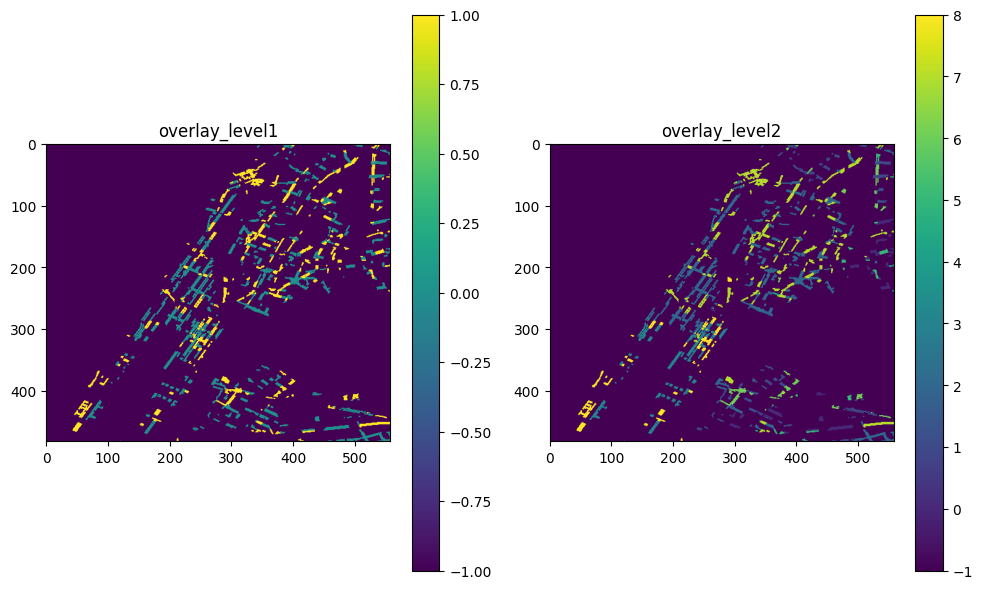

In [7]:
# Open the GeoTIFF file
tiff_path = "../data_pipeline/data/tiff/nyco_res30.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as dst:
    overlay_level1 = dst.read(1)
    overlay_level2 = dst.read(2)

band_name = ['overlay_level1', 'overlay_level2'] 
band_lst = [overlay_level1, overlay_level2]
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Flatten the axes for easier indexing
axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes[i].imshow(band_lst[i], cmap='viridis')
    axes[i].set_title(band_name[i])
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()


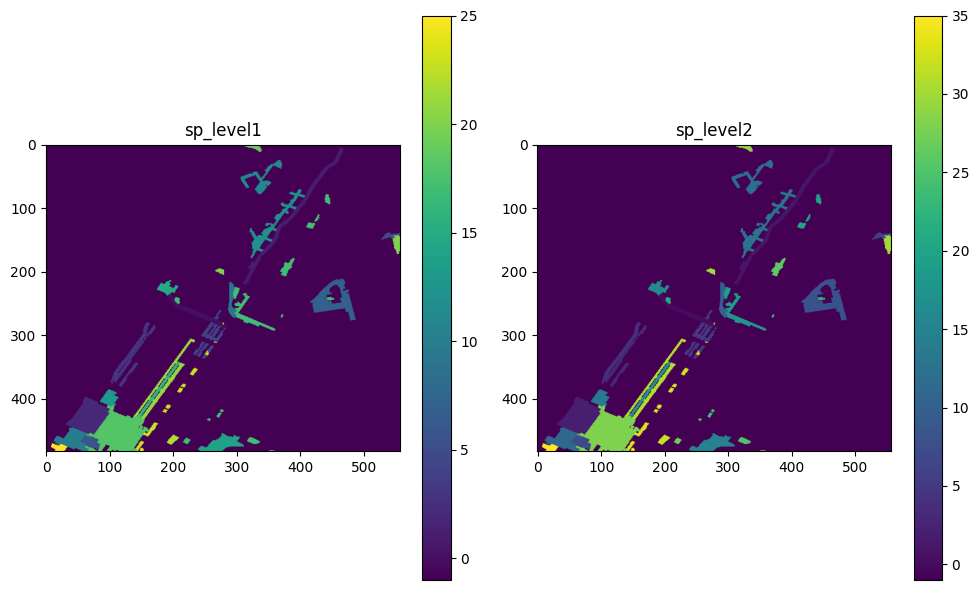

In [8]:
# Open the GeoTIFF file
tiff_path = "../data_pipeline/data/tiff/nysp_res30.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as dst:
    sp_level1 = dst.read(1)
    sp_level2 = dst.read(2)

band_name = ['sp_level1', 'sp_level2'] 
band_lst = [sp_level1, sp_level2]
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Flatten the axes for easier indexing
axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes[i].imshow(band_lst[i], cmap='viridis')
    axes[i].set_title(band_name[i])
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()


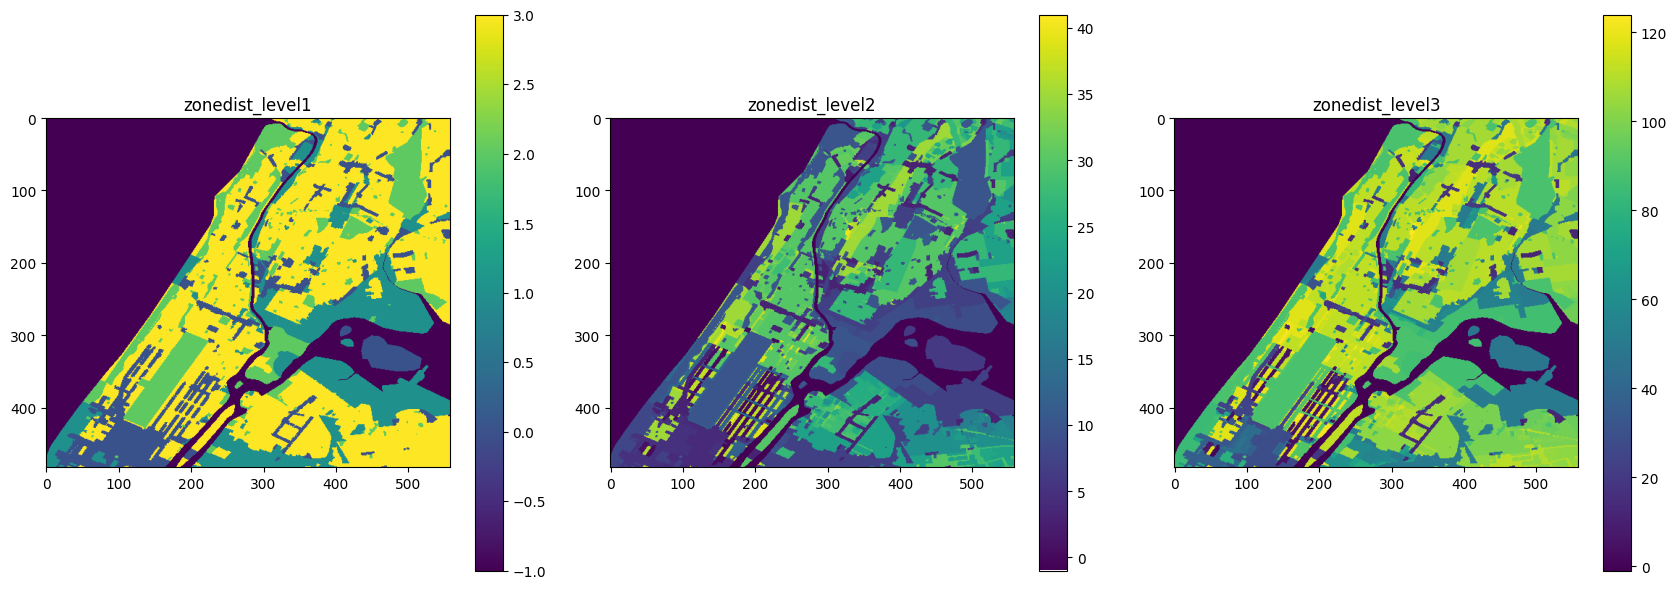

In [9]:
# Open the GeoTIFF file
tiff_path = "../data_pipeline/data/tiff/nyzd_res30.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as dst:
    zonedist_level1 = dst.read(1)
    zonedist_level2 = dst.read(2)
    zonedist_level3 = dst.read(3)

band_name = ['zonedist_level1', 'zonedist_level2', 'zonedist_level3'] 
band_lst = [zonedist_level1, zonedist_level2, zonedist_level3]
fig, axes = plt.subplots(1, 3, figsize=(17, 6))

# Flatten the axes for easier indexing
axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes[i].imshow(band_lst[i], cmap='viridis')
    axes[i].set_title(band_name[i])
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()


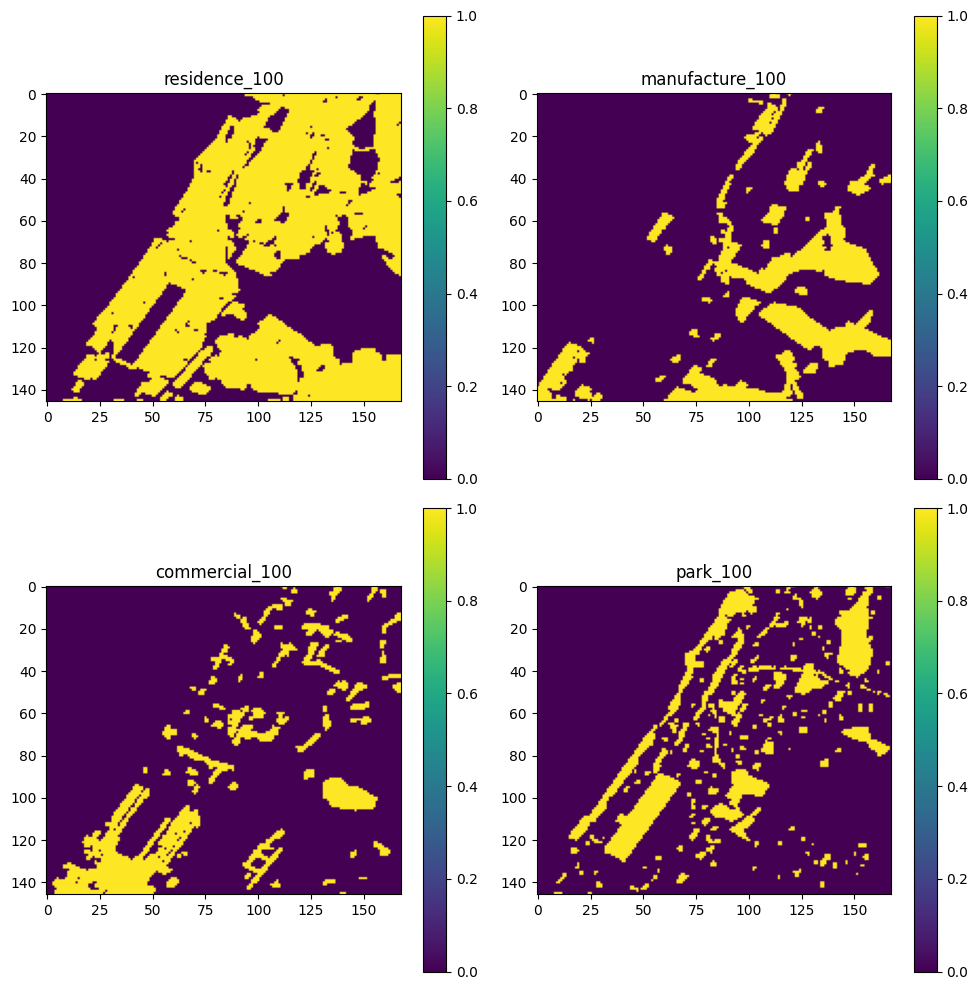

In [10]:
# Open the GeoTIFF file
tiff_path = "../data_pipeline/data/tiff/nyzd_res100.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as dst:
    residence_100 = dst.read(4)
    manufacture_100 = dst.read(5)
    commercial_100 = dst.read(6)
    park_100 = dst.read(7)

band_name = ['residence_100', 'manufacture_100', 'commercial_100', 'park_100'] 
band_lst = [residence_100, manufacture_100, commercial_100, park_100]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes[i].imshow(band_lst[i], cmap='viridis')
    axes[i].set_title(band_name[i])
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()


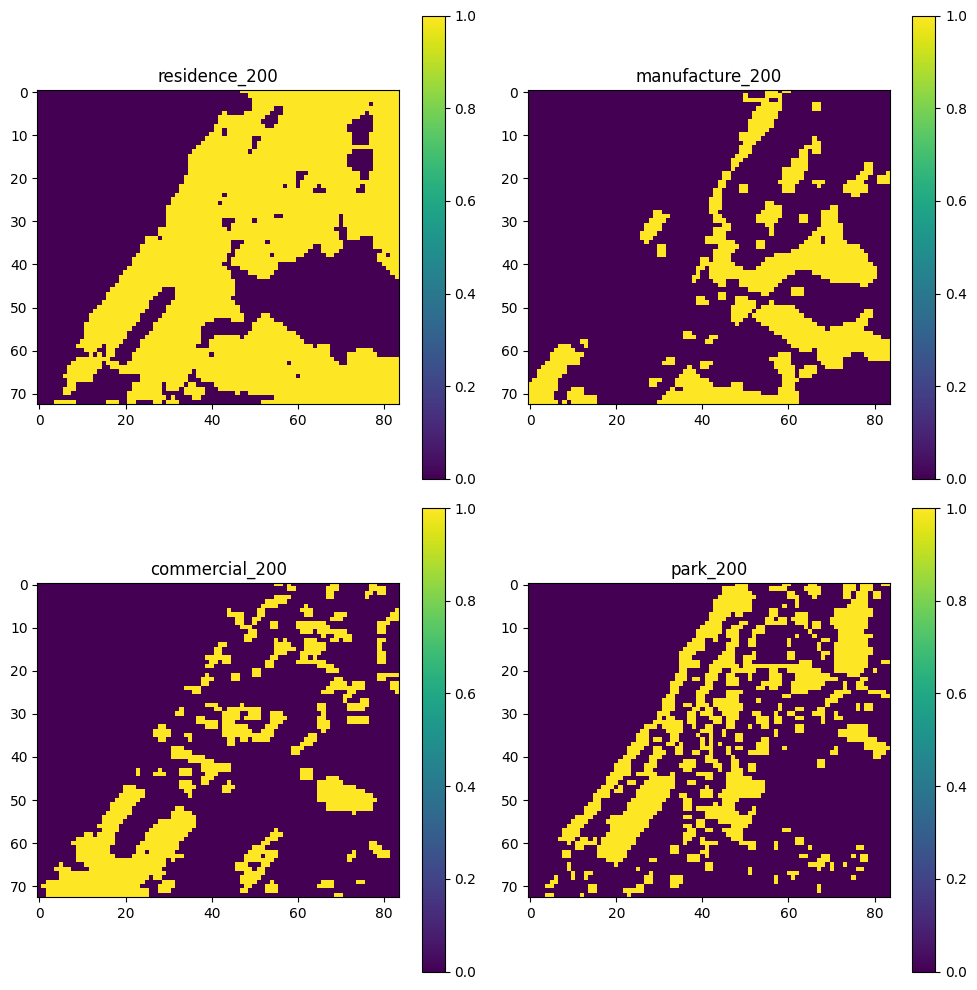

In [11]:
# Open the GeoTIFF file
tiff_path = "../data_pipeline/data/tiff/nyzd_res200.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as dst:
    residence_200 = dst.read(4)
    manufacture_200 = dst.read(5)
    commercial_200 = dst.read(6)
    park_200 = dst.read(7)

band_name = ['residence_200', 'manufacture_200', 'commercial_200', 'park_200'] 
band_lst = [residence_200, manufacture_200, commercial_200, park_200]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes[i].imshow(band_lst[i], cmap='viridis')
    axes[i].set_title(band_name[i])
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()

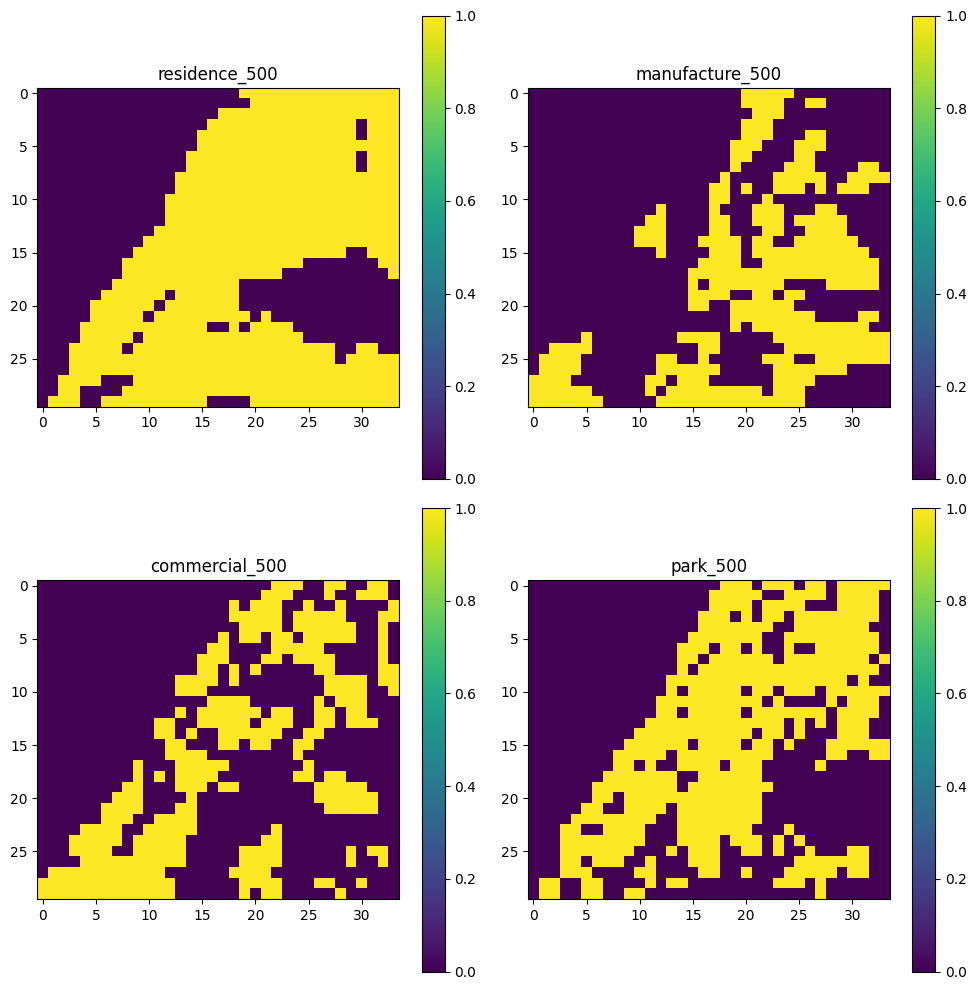

In [12]:
# Open the GeoTIFF file
tiff_path = "../data_pipeline/data/tiff/nyzd_res500.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as dst:
    residence_500 = dst.read(4)
    manufacture_500 = dst.read(5)
    commercial_500 = dst.read(6)
    park_500 = dst.read(7)

band_name = ['residence_500', 'manufacture_500', 'commercial_500', 'park_500'] 
band_lst = [residence_500, manufacture_500, commercial_500, park_500]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes[i].imshow(band_lst[i], cmap='viridis')
    axes[i].set_title(band_name[i])
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()

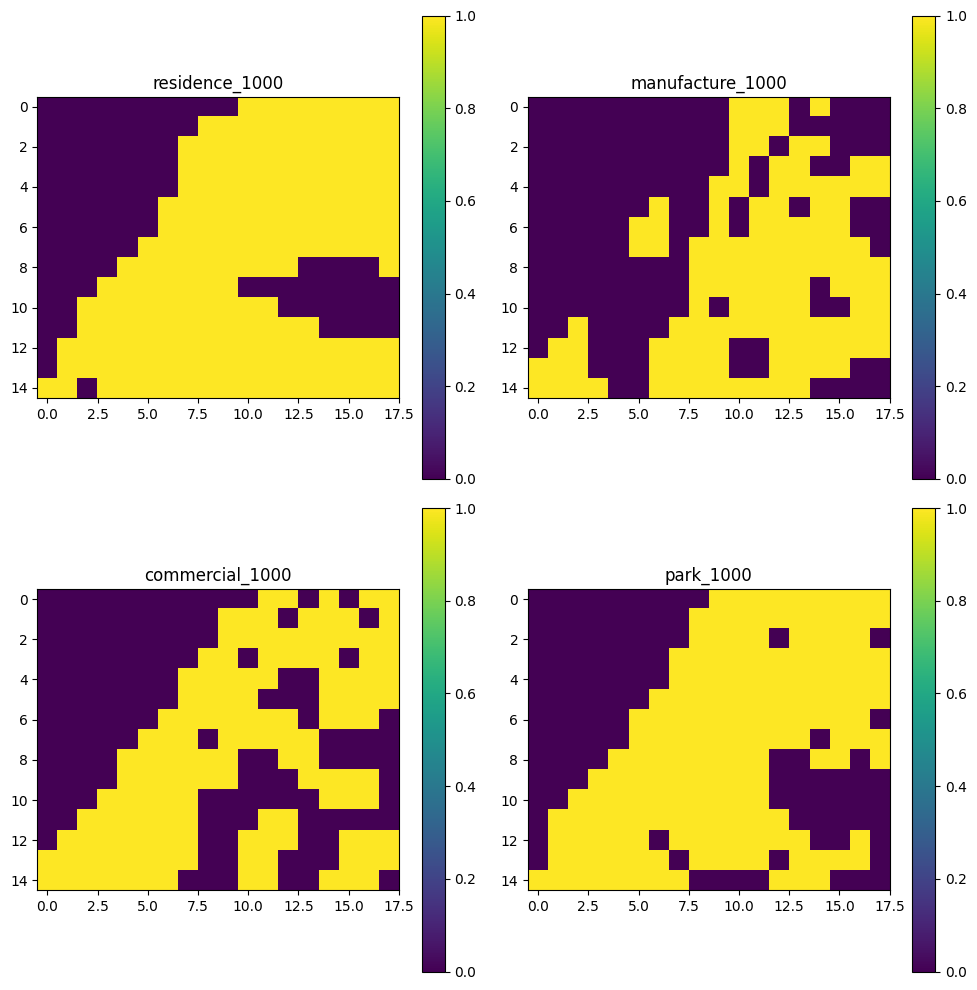

In [13]:
# Open the GeoTIFF file
tiff_path = "../data_pipeline/data/tiff/nyzd_res1000.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as dst:
    residence_1000 = dst.read(4)
    manufacture_1000 = dst.read(5)
    commercial_1000 = dst.read(6)
    park_1000 = dst.read(7)

band_name = ['residence_1000', 'manufacture_1000', 'commercial_1000', 'park_1000'] 
band_lst = [residence_1000, manufacture_1000, commercial_1000, park_1000]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes[i].imshow(band_lst[i], cmap='viridis')
    axes[i].set_title(band_name[i])
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()

In [75]:
read_folder = "../data_pipeline/data/tiff/air_quality/AOD/"
aod47_lst = []
aod55_lst = []

for i, filename in tqdm(enumerate(os.listdir(read_folder))):
    if filename.endswith(".tif") or filename.endswith(".tiff"):
        file_path = os.path.join(read_folder, filename)
        
        with rasterio.open(file_path) as dst:
            aod_47 = dst.read(1)
            aod_55 = dst.read(2)
            aod_uncertainty = dst.read(3)
            aod_qa = dst.read(4)
            transform = dst.transform
            crs = dst.crs
        aod47_lst.append(aod_47)
        aod55_lst.append(aod_55)

93it [00:01, 62.78it/s]


In [24]:
meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 557,
 'height': 483,
 'count': 8,
 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
 'transform': Affine(0.0002692998204667966, 0.0, -74.01,
        0.0, -0.0002691511387163614, 40.88)}

In [76]:
aod47_median = np.nanmedian(np.array(aod47_lst), axis=0)
aod55_median = np.nanmedian(np.array(aod55_lst), axis=0)

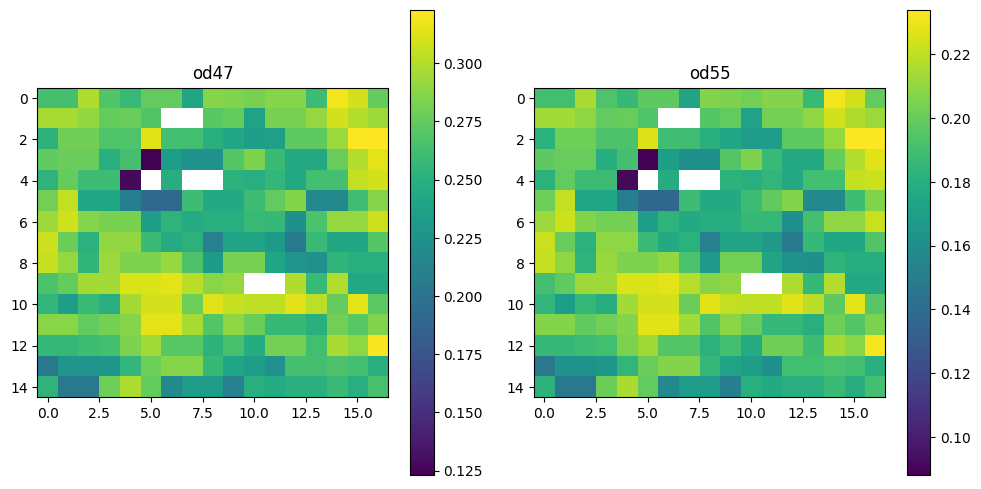

In [77]:
band_name = ['od47', 'od55'] 
band_lst = [aod47_median, aod55_median]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Flatten the axes for easier indexing
axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes[i].imshow(band_lst[i], cmap='viridis')
    axes[i].set_title(band_name[i])
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()


In [79]:
def nanmean_filter(matrix):
    nan_mask = np.isnan(matrix)
    filled_matrix = np.copy(matrix)

    # Compute mean using convolution (excluding NaNs)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if nan_mask[i, j]:  # If NaN, replace with local mean
                neighbors = []
                
                for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # Up, Down, Left, Right
                    ni, nj = i + di, j + dj
                    if 0 <= ni < matrix.shape[0] and 0 <= nj < matrix.shape[1]:
                        if not np.isnan(matrix[ni, nj]):
                            neighbors.append(matrix[ni, nj])

                if neighbors:
                    filled_matrix[i, j] = np.nanmean(neighbors)  # Replace with neighbor mean

    return filled_matrix

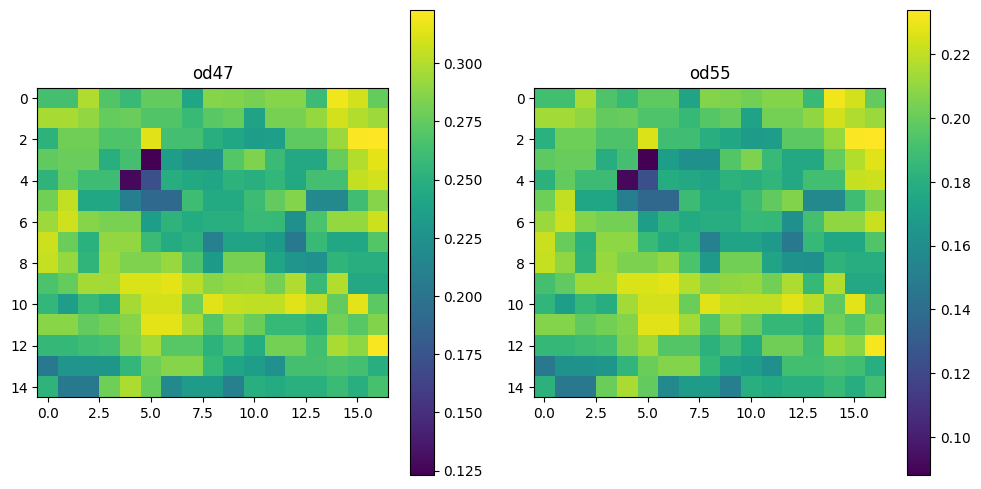

In [81]:
filled_aod55 = nanmean_filter(aod55_median)
filled_aod47 = nanmean_filter(aod47_median)

band_name = ['od47', 'od55'] 
band_lst = [filled_aod47, filled_aod55]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Flatten the axes for easier indexing
axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes[i].imshow(band_lst[i], cmap='viridis')
    axes[i].set_title(band_name[i])
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()


In [91]:
save_folder = "../data_pipeline/data/tiff/air_quality/AOD/"
filename = "AOD_median_3months.tif"
savefile = os.path.join(save_folder, filename)
with rasterio.open(savefile, 'w', driver='GTiff', count=2, crs=crs, transform=transform,
        dtype=filled_aod47.dtype,
        height=filled_aod47.shape[0], width=filled_aod47.shape[1]) as dst:
    dst.write(filled_aod47, 1)
    dst.write(filled_aod55, 2)

In [156]:
print(transform)

| 0.00, 0.00,-74.01|
| 0.00,-0.00, 40.88|
| 0.00, 0.00, 1.00|


In [40]:
population_res100.shape

(146, 168)

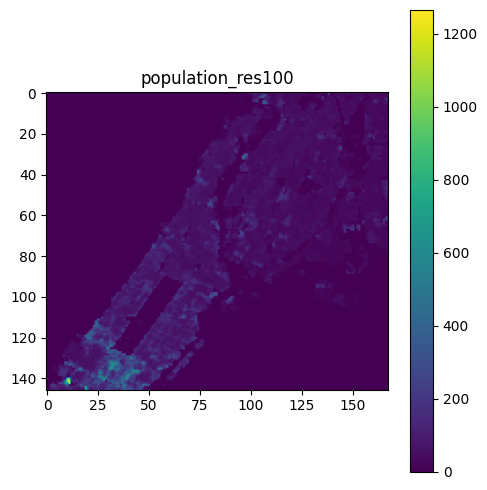

In [60]:
# Open the GeoTIFF file
tiff_path = "../data_pipeline/data/tiff/building_res100.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as dst:
    population_res100 = dst.read(1)

band_name = ['population_res100'] 
band_lst = [population_res100]
fig, axes = plt.subplots(1, 1, figsize=(5, 5))

# Flatten the axes for easier indexing
# axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes.imshow(band_lst[i], cmap='viridis')
    axes.set_title(band_name[i])
    fig.colorbar(im, ax=axes)

plt.tight_layout()
plt.show()

In [68]:
def smoothing_filter(raster_arr, operation, size=1):  # 3x3: size = 1, 5x5: size = 2
    m, n = raster_arr.shape
    smoothed_raster = np.zeros((m, n))

    for i in range(m):
        for j in range(n):
            neighbors = raster_arr[max(i-size, 0):min(i+1+size, m), max(j-size, 0):min(j+1+size, n)]
            if operation == "mean":
                smoothed_raster[i, j] = np.nanmean(neighbors)
            elif operation == "std_dev":
                smoothed_raster[i, j] = np.nanstd(neighbors)
            elif operation == "median":
                smoothed_raster[i, j] = np.nanmedian(neighbors)
            else:
                print("Only except mean, median, and std_dev operation.")

    return smoothed_raster

smoothed_raster = smoothing_filter(population_res100, 'mean', size=1)

In [69]:
population_res100[140:, 5:10]

array([[  0.      ,   0.      ,   0.      ,  80.      ,  80.      ],
       [ 22.      ,   0.      ,   0.      , 155.      , 483.66666 ],
       [  0.      , 245.03667 , 245.03667 , 252.44666 , 707.      ],
       [ 84.133415, 100.22342 , 137.49083 , 125.73055 , 259.5     ],
       [126.305695,  81.5817  ,  85.2834  ,  84.8884  , 128.55    ],
       [103.13976 ,  85.43651 ,  66.466515,  63.639744,  94.      ]],
      dtype=float32)

In [70]:
print(smoothed_raster[140:, 5:10])

[[  4.88888884   2.44444442  40.31887817 111.83738708 350.61517334]
 [ 32.1151886   56.89704132 108.61333466 222.57220459 512.67926025]
 [ 74.7926178   92.65789032 140.10720825 262.87460327 485.22335815]
 [112.52825165 122.78797913 150.85758972 225.10295105 327.97579956]
 [118.11265564  96.67346954  92.30456543 116.17215729 170.77503967]
 [113.15283203  91.368927    77.88271332  87.13800812 102.1796875 ]]


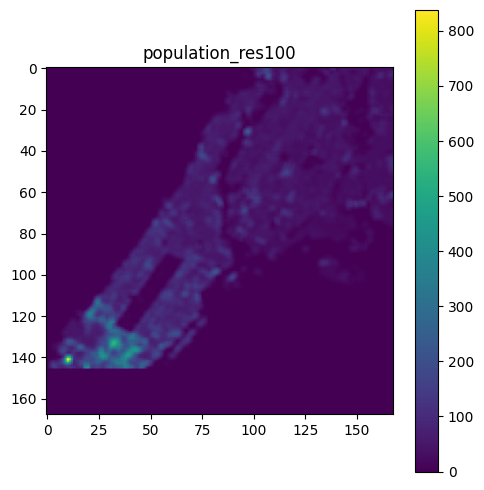

In [64]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))

im = axes.imshow(smoothed_raster, cmap='viridis')
axes.set_title(band_name[i])
fig.colorbar(im, ax=axes)

plt.tight_layout()
plt.show()

In [56]:
print(population_res100[80:85, 80:85])

[[ 55.046173  48.813957  60.691154  74.899605 105.63098 ]
 [ 52.79647   45.33286   78.46      66.710175   0.      ]
 [ 39.76      61.47333   77.9       63.77       0.      ]
 [ 56.191574  75.627884  76.57      51.84791   37.533333]
 [ 56.751503  62.21525   87.7991    94.40749   43.88215 ]]


In [58]:
print(population_res100[80:85, 80:85])

[[50.281536 48.563675 49.27393  48.949753 48.19335 ]
 [61.923992 51.381737 49.47956  48.076046 48.9608  ]
 [85.00849  66.5916   57.133877 48.986706 50.840828]
 [96.83385  72.45162  58.795696 44.49922  53.03185 ]
 [85.907845 62.851387 45.95196  28.629774 46.480305]]


In [36]:
desc

('no2_july24',)

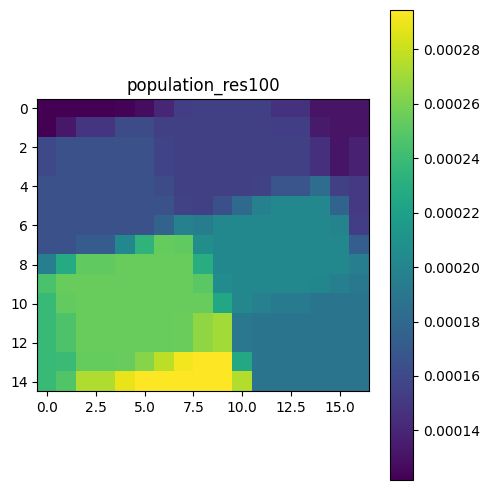

In [35]:
# Open the GeoTIFF file
tiff_path = "../data_pipeline/data/tiff/no2_20210724_165223.tif"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as dst:
    population_res100 = dst.read(1)
    desc = dst.descriptions
    count = dst.count

band_name = ['population_res100'] 
band_lst = [population_res100]
fig, axes = plt.subplots(1, 1, figsize=(5, 5))

# Flatten the axes for easier indexing
# axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes.imshow(band_lst[i], cmap='viridis')
    axes.set_title(band_name[i])
    fig.colorbar(im, ax=axes)

plt.tight_layout()
plt.show()

### Extracting Band Values from the GeoTIFF Image


In [83]:
training_data_path = '../Training_data_uhi_index_2025-02-18.csv'
# Mapping satellite data with training data.
data_dir = "../data_pipeline/data/tiff/"


In [84]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data(tiff_path, csv_path, col_name):
    
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    layer_num = 0
    with rasterio.open(tiff_path) as dts:
        layer_num = dts.count

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values   

    df = pd.DataFrame()
    for i in tqdm(range(layer_num), desc="Go through layer"):
        values = []
        # Iterate over the latitudes and longitudes, and extract the corresponding band values
        for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
        # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
            cell_value = data.sel(x=lon, y=lat,  band=i+1, method="nearest").values
            values.append(cell_value)
        # Add column of feature
        df[col_name[i]] = values
    
    return df


#### Landsat8 bands

In [6]:
landsat_bands = ['red', 'blue', 'green', 'nir08', 'swir16', 'swir22', 'coastal', 'lwir11']
landsat_data = map_satellite_data(data_dir+'landsat_8.tiff', training_data_path,
                                landsat_bands)

Go through layer: 100%|██████████| 8/8 [02:05<00:00, 15.70s/it]


#### Building bands

In [7]:
# Mapping satellite data with training data.
building_bands = ['building_height', 'building_sd', 'building_year', 'building_area']
building_data = map_satellite_data(data_dir+'building_res30.tiff', training_data_path,
                                building_bands)

Go through layer:   0%|          | 0/4 [00:00<?, ?it/s]

Go through layer: 100%|██████████| 4/4 [01:00<00:00, 15.16s/it]


#### Street bands

In [8]:
# Mapping satellite data with training data.
street_bands = ['street_width', 'street_traffic', 'street_lane', 'street_orientation']
street_data = map_satellite_data(data_dir+'street_res30.tiff', training_data_path,
                                street_bands)

Go through layer: 100%|██████████| 4/4 [01:00<00:00, 15.05s/it]


#### Zoning bands

In [9]:
nyco_bands = ['overlay_level1', 'overlay_level2']
nyco_data = map_satellite_data(data_dir+'nyco_res30.tiff', training_data_path,
                                nyco_bands)

Go through layer: 100%|██████████| 2/2 [00:32<00:00, 16.44s/it]


In [10]:
nysp_bands = ['sp_level1', 'sp_level2']
nysp_data = map_satellite_data(data_dir+'nysp_res30.tiff', training_data_path,
                                nysp_bands)

Go through layer:   0%|          | 0/2 [00:00<?, ?it/s]

Go through layer: 100%|██████████| 2/2 [00:35<00:00, 17.99s/it]


In [11]:
nyzd30_bands = ['zonedist_level1_30', 'zonedist_level2_30', 'zonedist_level3_30', 'residence_30', 'manufacture_30', 'commercial_30', 'park_30']
nyzd30_data = map_satellite_data(data_dir+'nyzd_res30.tiff', training_data_path,
                                nyzd30_bands)

Go through layer:   0%|          | 0/7 [00:00<?, ?it/s]

Go through layer: 100%|██████████| 7/7 [01:45<00:00, 15.03s/it]


In [12]:
nyzd100_bands = ['zonedist_level1_100', 'zonedist_level2_100', 'zonedist_level3_100', 'residence_100', 'manufacture_100', 'commercial_100', 'park_100']
nyzd100_data = map_satellite_data(data_dir+'nyzd_res100.tiff', training_data_path,
                                nyzd100_bands)

Go through layer:   0%|          | 0/7 [00:00<?, ?it/s]

Go through layer: 100%|██████████| 7/7 [01:54<00:00, 16.37s/it]


In [13]:
nyzd200_bands = ['zonedist_level1_200', 'zonedist_level2_200', 'zonedist_level3_200', 'residence_200', 'manufacture_200', 'commercial_200', 'park_200']
nyzd200_data = map_satellite_data(data_dir+'nyzd_res200.tiff', training_data_path,
                                nyzd200_bands)

Go through layer: 100%|██████████| 7/7 [01:57<00:00, 16.78s/it]


In [14]:
nyzd500_bands = ['zonedist_level1_500', 'zonedist_level2_500', 'zonedist_level3_500', 'residence_500', 'manufacture_500', 'commercial_500', 'park_500']
nyzd500_data = map_satellite_data(data_dir+'nyzd_res500.tiff', training_data_path,
                                nyzd500_bands)

Go through layer: 100%|██████████| 7/7 [01:52<00:00, 16.08s/it]


In [15]:
nyzd1000_bands = ['zonedist_level1_1000', 'zonedist_level2_1000', 'zonedist_level3_1000', 'residence_1000', 'manufacture_1000', 'commercial_1000', 'park_1000']
nyzd1000_data = map_satellite_data(data_dir+'nyzd_res1000.tiff', training_data_path,
                                nyzd1000_bands)

Go through layer: 100%|██████████| 7/7 [01:51<00:00, 15.89s/it]


#### AOD bands

In [92]:
tif_path = "../data_pipeline/data/tiff/air_quality/AOD/AOD_median_3months.tif"
aod_bands = [ 
    "aod_47",
    "aod_55"
]
aod_data = map_satellite_data(csv_path=training_data_path,
                              tiff_path=tif_path,
                              col_name=aod_bands)


Go through layer: 100%|██████████| 2/2 [00:31<00:00, 15.63s/it]


#### Air Quality bands

In [93]:
aq_path = "../data_pipeline/data/tiff/air_quality/AQ/"

co_bands = ['co']
hcho_bands = ['hcho']
no2_bands = ['no2']
o3_bands = ['o3']
so2_bands = ['so2']

co_data = map_satellite_data(csv_path=training_data_path, tiff_path=aq_path+"co_20210724_165223.tif", col_name=co_bands)
hcho_data = map_satellite_data(csv_path=training_data_path, tiff_path=aq_path+"hcho_20210724_165223.tif", col_name=hcho_bands)
no2_data = map_satellite_data(csv_path=training_data_path, tiff_path=aq_path+"no2_20210724_165223.tif", col_name=no2_bands)
o3_data = map_satellite_data(csv_path=training_data_path, tiff_path=aq_path+"o3_20210724_165223.tif", col_name=o3_bands)
so2_data = map_satellite_data(csv_path=training_data_path, tiff_path=aq_path+"so2_20210724_165223.tif", col_name=so2_bands)

Go through layer: 100%|██████████| 1/1 [00:15<00:00, 15.74s/it]


In [162]:
population_data = map_satellite_data(csv_path=training_data_path, tiff_path="../data_pipeline/data/tiff/population_res1000.tiff", col_name=['population'])

Go through layer: 100%|██████████| 1/1 [00:17<00:00, 17.32s/it]


In [165]:
# aod_data.to_csv("../data_pipeline/data/tabular_data/train/aod_median_3months.csv")
# co_data.to_csv("../data_pipeline/data/tabular_data/train/co_july24.csv")
# hcho_data.to_csv("../data_pipeline/data/tabular_data/train/hcho_july24.csv")
# no2_data.to_csv("../data_pipeline/data/tabular_data/train/no2_july24.csv")
# o3_data.to_csv("../data_pipeline/data/tabular_data/train/o3_july24.csv")
# so2_data.to_csv("../data_pipeline/data/tabular_data/train/so2_july24.csv")
# population_data.to_csv("../data_pipeline/data/tabular_data/train/population_res100.csv")
population_data.to_csv("../data_pipeline/data/tabular_data/train/population_res1000.csv")

In [18]:
landsat_data.to_csv("../data_pipeline/data/tabular_data/train/landsat_res30.csv")
building_data.to_csv("../data_pipeline/data/tabular_data/train/building_res30.csv")
street_data.to_csv("../data_pipeline/data/tabular_data/train/street_res30.csv")
nyco_data.to_csv("../data_pipeline/data/tabular_data/train/nyco_res30.csv")
nysp_data.to_csv("../data_pipeline/data/tabular_data/train/nysp_res30.csv")
nyzd30_data.to_csv("../data_pipeline/data/tabular_data/train/nyzd_res30.csv")
nyzd100_data.to_csv("../data_pipeline/data/tabular_data/train/nyzd_res100.csv")
nyzd200_data.to_csv("../data_pipeline/data/tabular_data/train/nyzd_res200.csv")
nyzd500_data.to_csv("../data_pipeline/data/tabular_data/train/nyzd_res500.csv")
nyzd1000_data.to_csv("../data_pipeline/data/tabular_data/train/nyzd_res1000.csv")

### Environmental Indices


In [166]:
df = pd.read_csv('../Training_data_uhi_index_2025-02-18.csv')
df = pd.concat([df, landsat_data, building_data, street_data, nyco_data, nysp_data, nyzd30_data, nyzd100_data, nyzd200_data, nyzd500_data, nyzd1000_data,
                aod_data, co_data, hcho_data, no2_data, o3_data, so2_data, population_data], axis=1)

print(df.shape)
df.head()

(11229, 67)


Longitude   Latitude          datetime  UHI Index                  red  \
0 -73.909167  40.813107  24-07-2021 15:53   1.030289            0.0713975   
1 -73.909187  40.813045  24-07-2021 15:53   1.030289            0.0713975   
2 -73.909215  40.812978  24-07-2021 15:53   1.023798  0.10783500000000001   
3 -73.909242  40.812908  24-07-2021 15:53   1.023798  0.10783500000000001   
4 -73.909257  40.812845  24-07-2021 15:53   1.021634  0.10783500000000001   

                  blue                green                nir08   swir16  \
0  0.04560249999999999  0.06952750000000002              0.20887  0.13649   
1  0.04560249999999999  0.06952750000000002              0.20887  0.13649   
2              0.08875  0.10676249999999998  0.23001749999999999    0.185   
3              0.08875  0.10676249999999998  0.23001749999999999    0.185   
4              0.08875  0.10676249999999998  0.23001749999999999    0.185   

                swir22  ... commercial_1000 park_1000 aod_47 aod_55  \
0  0.09543249999999998  ...             1.0       1.0  0.232  0.167   
1  0.09543249999999998  ...             1.0       1.0  0.232  0.167   
2            0.1352525  ...             1.0       1.0  0.232  0.167   
3            0.1352525  ...             1.0       1.0  0.232  0.167   
4            0.1352525  ...             1.0       1.0  0.232  0.167   

                    co                    hcho                    no2  \
0  0.04738928286719038  0.00014126741734797417  0.0002023973211180192   
1  0.04738928286719038  0.00014126741734797417  0.0002023973211180192   
2  0.04738928286719038  0.00014126741734797417  0.0002023973211180192   
3  0.04738928286719038  0.00014126741734797417  0.0002023973211180192   
4  0.04738928286719038  0.00014126741734797417  0.0002023973211180192   

                    o3                      so2          population  
0  0.14792844653127923  -0.00016137768398037238  13130.602418037339  
1  0.14792844653127923  -0.00016137768398037238  13130.602418037339  
2  0.14792844653127923  -0.00016137768398037238  13130.602418037339  
3  0.14792844653127923  -0.00016137768398037238  13130.602418037339  
4  0.14792844653127923  -0.00016137768398037238  13130.602418037339  

[5 rows x 67 columns]

In [97]:
def calculate_indices(df):
    df['ndvi'] = (df['nir08'] - df['red']) / (df['nir08'] + df['red'])

    # EVI (Enhanced Vegetation Index)
    df["evi"] = 2.5 * (df['nir08'] - df['red']) / (df['nir08'] + 6 * df['red'] - 7.5 * df['blue'] + 1 + 1e-10)

    # SAVI (Soil Adjusted Vegetation Index)
    df["savi"] = (df['nir08'] - df['red']) * 1.5 / (df['nir08'] + df['red'] + 0.5 + 1e-10)

    # GNDVI (Green Normalized Difference Vegetation Index)
    df["gndvi"] = (df['nir08'] - df['green']) / (df['nir08'] + df['green'] + 1e-10)

    # ARVI (Atmospherically Resistant Vegetation Index)
    df["arvi"] = (df['nir08'] - (df['red'] - (df['blue'] - df['red']))) / (df['nir08'] + (df['red'] - (df['blue'] - df['red'])) + 1e-10)

    # MSAVI (Modified Soil-Adjusted Vegetation Index)
    df["msavi"] = (2 * df['nir08'] + 1 - ((2 * df['nir08'] + 1) ** 2 - 8 * (df['nir08'] - df['red'])) ** 0.5) / 2

    # NDWI (Normalized Difference Water Index)
    df['ndwi'] = (df['green'] - df['nir08']) / (df['green'] + df['nir08'])

    # MNDWI (Modified Normalized Difference Water Index)
    df["mndwi"] = (df['green'] - df['swir16']) / (df['green'] + df['swir16'] + 1e-10)

    # AWEI_NSH (Automated Water Extraction Index - No Shadows)
    df["awei_nsh"] = 4 * (df['green'] - df['swir16']) - (0.25 * df['nir08'] + 2.75 * df['swir22'])

    # AWEI_SH (Automated Water Extraction Index - Shadows)
    df["awei_sh"] = df['green'] + 2.5 * df['nir08'] - 1.5 * (df['swir16'] + df['swir22']) - 0.25 * df['blue']

    # NDSI (Normalized Difference Snow Index)
    df["ndsi"] = (df['green'] - df['swir16']) / (df['green'] + df['swir16'] + 1e-10)

    # NBR (Normalized Burn Ratio)
    df["nbr"] = (df['nir08'] - df['swir22']) / (df['nir08'] + df['swir22'] + 1e-10)

    # SI (Shadow Index or Soil Index)
    df["si"] = (df['swir16'] - df['blue']) / (df['swir16'] + df['blue'] + 1e-10)
        
    # NDBI (Normalized Difference Building Index)
    df['ndbi'] = (df['swir16'] - df['nir08']) / (df['swir16'] + df['nir08'])

    # UI (Urban Index)
    df["ui"] = (df['swir16'] - df['red']) / (df['swir16'] + df['red'] + 1e-10)

    # IBI (Index-based Built-up Index)
    df["ibi"] = (df["ndbi"] - (df["savi"] + df["mndwi"])) / (df["ndbi"] + (df["savi"] + df["mndwi"]) + 1e-10)
                                                            
    # Albedo (Surface Reflectance Index)
    df['albedo'] = (0.356 * df['blue'] + 0.130 * df['red'] + 0.373 * df['nir08'] + 0.085 * df['swir16'] + 0.072 * df['swir22'] - 0.018) / 1.016

    # Calculate the VAR (Vertical Aspect Ratio)
    df['var'] = df['building_height'] / df['street_width']
    df['var'] = df['var'].replace([np.inf, -np.inf], np.nan)
    df['var'] = df['var'].replace(np.nan, 1000)

    # Calculate the building's area per pixel area (30 x 30 m^2)
    df['building_area_per_pixel'] = df['building_area'] / (900 * 10.764)
    df['building_area_per_pixel'] = df['building_area_per_pixel'].replace([np.inf, -np.inf], np.nan)

    return df


In [167]:
df = calculate_indices(df)
print(df.shape)
df.head()

(11229, 86)


Longitude   Latitude          datetime  UHI Index                  red  \
0 -73.909167  40.813107  24-07-2021 15:53   1.030289            0.0713975   
1 -73.909187  40.813045  24-07-2021 15:53   1.030289            0.0713975   
2 -73.909215  40.812978  24-07-2021 15:53   1.023798  0.10783500000000001   
3 -73.909242  40.812908  24-07-2021 15:53   1.023798  0.10783500000000001   
4 -73.909257  40.812845  24-07-2021 15:53   1.021634  0.10783500000000001   

                  blue                green                nir08   swir16  \
0  0.04560249999999999  0.06952750000000002              0.20887  0.13649   
1  0.04560249999999999  0.06952750000000002              0.20887  0.13649   
2              0.08875  0.10676249999999998  0.23001749999999999    0.185   
3              0.08875  0.10676249999999998  0.23001749999999999    0.185   
4              0.08875  0.10676249999999998  0.23001749999999999    0.185   

                swir22  ...   awei_sh      ndsi       nbr        si      ndbi  \
0  0.09543249999999998  ...  0.232418 -0.325033  0.372779  0.499128 -0.209578   
1  0.09543249999999998  ...  0.232418 -0.325033  0.372779  0.499128 -0.209578   
2            0.1352525  ...   0.17924 -0.268155  0.259438  0.351598 -0.108471   
3            0.1352525  ...   0.17924 -0.268155  0.259438  0.351598 -0.108471   
4            0.1352525  ...   0.17924 -0.268155  0.259438  0.351598 -0.108471   

         ui       ibi    albedo       var building_area_per_pixel  
0  0.313114  0.550527  0.102261  1.479545                 0.09663  
1  0.313114  0.550527  0.102261  1.479545                 0.09663  
2   0.26351  0.374065  0.136686  0.000000                 0.00000  
3   0.26351  0.374065  0.136686  0.000000                 0.00000  
4   0.26351  0.374065  0.136686  0.000000                 0.00000  

[5 rows x 86 columns]

## EDA

In [168]:
df = df.drop(columns=['datetime'])
df = df.astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 85 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Longitude                11229 non-null  float64
 1   Latitude                 11229 non-null  float64
 2   UHI Index                11229 non-null  float64
 3   red                      11229 non-null  float64
 4   blue                     11229 non-null  float64
 5   green                    11229 non-null  float64
 6   nir08                    11229 non-null  float64
 7   swir16                   11229 non-null  float64
 8   swir22                   11229 non-null  float64
 9   coastal                  11229 non-null  float64
 10  lwir11                   11229 non-null  float64
 11  building_height          11229 non-null  float64
 12  building_sd              11229 non-null  float64
 13  building_year            11229 non-null  float64
 14  building_area         

In [169]:
df.columns

Index(['Longitude', 'Latitude', 'UHI Index', 'red', 'blue', 'green', 'nir08',
       'swir16', 'swir22', 'coastal', 'lwir11', 'building_height',
       'building_sd', 'building_year', 'building_area', 'street_width',
       'street_traffic', 'street_lane', 'street_orientation', 'overlay_level1',
       'overlay_level2', 'sp_level1', 'sp_level2', 'zonedist_level1_30',
       'zonedist_level2_30', 'zonedist_level3_30', 'residence_30',
       'manufacture_30', 'commercial_30', 'park_30', 'zonedist_level1_100',
       'zonedist_level2_100', 'zonedist_level3_100', 'residence_100',
       'manufacture_100', 'commercial_100', 'park_100', 'zonedist_level1_200',
       'zonedist_level2_200', 'zonedist_level3_200', 'residence_200',
       'manufacture_200', 'commercial_200', 'park_200', 'zonedist_level1_500',
       'zonedist_level2_500', 'zonedist_level3_500', 'residence_500',
       'manufacture_500', 'commercial_500', 'park_500', 'zonedist_level1_1000',
       'zonedist_level2_1000', 'zonedis

In [170]:
excluded_cols = ['Longitude', 'Latitude', 'UHI Index',]
categorical_cols = ['street_traffic', 'street_orientation'] + nyco_bands + nysp_bands + nyzd30_bands + nyzd100_bands + nyzd200_bands + nyzd500_bands + nyzd1000_bands

excluded_feautures = [
    'overlay_level2', 'sp_level1', 'sp_level2', 'zonedist_level3_30', 'zonedist_level2_30', 'residence_30',
    'manufacture_30', 'commercial_30', 'park_30', 
    'zonedist_level1_100',
    'zonedist_level2_100', 'zonedist_level3_100', 'zonedist_level1_200',
    'zonedist_level2_200', 'zonedist_level3_200', 'zonedist_level1_500',
    'zonedist_level2_500', 'zonedist_level3_500', 'zonedist_level1_1000',
    'zonedist_level2_1000', 'zonedist_level3_1000'
]
df[categorical_cols] = df[categorical_cols].astype('category')

cat_col_included = list(set(categorical_cols) - set(excluded_feautures))
numerical_cols = df.columns.difference(cat_col_included + excluded_cols + excluded_feautures)

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 85 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Longitude                11229 non-null  float64 
 1   Latitude                 11229 non-null  float64 
 2   UHI Index                11229 non-null  float64 
 3   red                      11229 non-null  float64 
 4   blue                     11229 non-null  float64 
 5   green                    11229 non-null  float64 
 6   nir08                    11229 non-null  float64 
 7   swir16                   11229 non-null  float64 
 8   swir22                   11229 non-null  float64 
 9   coastal                  11229 non-null  float64 
 10  lwir11                   11229 non-null  float64 
 11  building_height          11229 non-null  float64 
 12  building_sd              11229 non-null  float64 
 13  building_year            11229 non-null  float64 
 14  buildi

## Data Preprocesing

In [172]:
uhi_data = df.drop(columns=(['Longitude', 'Latitude'] + excluded_feautures))
uhi_data

UHI Index       red      blue     green     nir08    swir16    swir22  \
0       1.030289  0.071398  0.045602  0.069528  0.208870  0.136490  0.095432   
1       1.030289  0.071398  0.045602  0.069528  0.208870  0.136490  0.095432   
2       1.023798  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
3       1.023798  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
4       1.021634  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
...          ...       ...       ...       ...       ...       ...       ...   
11224   0.972470  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11225   0.972470  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11226   0.981124  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11227   0.981245  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11228   0.983408  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   

        coastal     lwir11  building_height  ...   awei_sh      ndsi  \
0      0.039250  37.785534        65.099998  ...  0.232418 -0.325033   
1      0.039250  37.785534        65.099998  ...  0.232418 -0.325033   
2      0.075742  37.358281         0.000000  ...  0.179240 -0.268155   
3      0.075742  37.358281         0.000000  ...  0.179240 -0.268155   
4      0.075742  37.358281         0.000000  ...  0.179240 -0.268155   
...         ...        ...              ...  ...       ...       ...   
11224  0.048627  30.440209         0.000000  ...  0.473263 -0.413842   
11225  0.048627  30.440209         0.000000  ...  0.473263 -0.413842   
11226  0.048627  30.440209         0.000000  ...  0.473263 -0.413842   
11227  0.048627  30.440209         0.000000  ...  0.473263 -0.413842   
11228  0.048627  30.440209         0.000000  ...  0.473263 -0.413842   

            nbr        si      ndbi        ui       ibi    albedo       var  \
0      0.372779  0.499128 -0.209578  0.313114  0.550527  0.102261  1.479545   
1      0.372779  0.499128 -0.209578  0.313114  0.550527  0.102261  1.479545   
2      0.259438  0.351598 -0.108471  0.263510  0.374065  0.136686  0.000000   
3      0.259438  0.351598 -0.108471  0.263510  0.374065  0.136686  0.000000   
4      0.259438  0.351598 -0.108471  0.263510  0.374065  0.136686  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
11224  0.524984  0.561994 -0.296239  0.476156  1.298300  0.154906  0.000000   
11225  0.524984  0.561994 -0.296239  0.476156  1.298300  0.154906  0.000000   
11226  0.524984  0.561994 -0.296239  0.476156  1.298300  0.154906  0.000000   
11227  0.524984  0.561994 -0.296239  0.476156  1.298300  0.154906  0.000000   
11228  0.524984  0.561994 -0.296239  0.476156  1.298300  0.154906  0.000000   

      building_area_per_pixel  
0                     0.09663  
1                     0.09663  
2                     0.00000  
3                     0.00000  
4                     0.00000  
...                       ...  
11224                 0.00000  
11225                 0.00000  
11226                 0.00000  
11227                 0.00000  
11228                 0.00000  

[11229 rows x 62 columns]

### Removing duplicates

In [173]:
# Check the duplicated records
print(f'Duplicated Rows: {uhi_data.duplicated().sum()}')
uhi_data.columns

Duplicated Rows: 3378


Index(['UHI Index', 'red', 'blue', 'green', 'nir08', 'swir16', 'swir22',
       'coastal', 'lwir11', 'building_height', 'building_sd', 'building_year',
       'building_area', 'street_width', 'street_traffic', 'street_lane',
       'street_orientation', 'overlay_level1', 'zonedist_level1_30',
       'residence_100', 'manufacture_100', 'commercial_100', 'park_100',
       'residence_200', 'manufacture_200', 'commercial_200', 'park_200',
       'residence_500', 'manufacture_500', 'commercial_500', 'park_500',
       'residence_1000', 'manufacture_1000', 'commercial_1000', 'park_1000',
       'aod_47', 'aod_55', 'co', 'hcho', 'no2', 'o3', 'so2', 'population',
       'ndvi', 'evi', 'savi', 'gndvi', 'arvi', 'msavi', 'ndwi', 'mndwi',
       'awei_nsh', 'awei_sh', 'ndsi', 'nbr', 'si', 'ndbi', 'ui', 'ibi',
       'albedo', 'var', 'building_area_per_pixel'],
      dtype='object')

In [174]:
uhi_data = uhi_data.drop_duplicates(keep='first')

In [175]:
# Resetting the index of the dataset
uhi_data = uhi_data.reset_index(drop=True)

### Encoding

In [176]:
# One-hot encodiing
# encoder = OneHotEncoder(sparse_output=False)
# ohe = encoder.fit_transform(uhi_data[categorical_cols])
uhi_data = pd.get_dummies(uhi_data, columns=cat_col_included)
uhi_data

UHI Index       red      blue     green     nir08    swir16    swir22  \
0      1.030289  0.071398  0.045602  0.069528  0.208870  0.136490  0.095432   
1      1.023798  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
2      1.021634  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
3      1.015143  0.182663  0.112262  0.159618  0.245830  0.226635  0.187200   
4      1.012979  0.182663  0.112262  0.159618  0.245830  0.226635  0.187200   
...         ...       ...       ...       ...       ...       ...       ...   
7846   0.972470  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
7847   0.972470  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
7848   0.981124  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
7849   0.981245  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
7850   0.983408  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   

       coastal     lwir11  building_height  ...  manufacture_200_0.0  \
0     0.039250  37.785534        65.099998  ...                 True   
1     0.075742  37.358281         0.000000  ...                 True   
2     0.075742  37.358281         0.000000  ...                 True   
3     0.092710  37.091675        12.830000  ...                 True   
4     0.092710  37.091675        12.830000  ...                 True   
...        ...        ...              ...  ...                  ...   
7846  0.048627  30.440209         0.000000  ...                 True   
7847  0.048627  30.440209         0.000000  ...                 True   
7848  0.048627  30.440209         0.000000  ...                 True   
7849  0.048627  30.440209         0.000000  ...                 True   
7850  0.048627  30.440209         0.000000  ...                 True   

      manufacture_200_1.0  manufacture_500_0.0  manufacture_500_1.0  \
0                   False                False                 True   
1                   False                False                 True   
2                   False                False                 True   
3                   False                False                 True   
4                   False                False                 True   
...                   ...                  ...                  ...   
7846                False                 True                False   
7847                False                 True                False   
7848                False                 True                False   
7849                False                 True                False   
7850                False                 True                False   

      commercial_100_0.0  commercial_100_1.0  park_500_0.0  park_500_1.0  \
0                   True               False         False          True   
1                   True               False         False          True   
2                   True               False         False          True   
3                   True               False         False          True   
4                   True               False         False          True   
...                  ...                 ...           ...           ...   
7846                True               False         False          True   
7847                True               False         False          True   
7848                True               False         False          True   
7849                True               False         False          True   
7850                True               False         False          True   

      manufacture_1000_0.0  manufacture_1000_1.0  
0                    False                  True  
1                    False                  True  
2                    False                  True  
3                    False                  True  
4                    False                  True  
...                    ...                   ...  
7846                  True                 False  
7847              

## Model Building

### Train and Test Split 

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [177]:
# Split the data into features (X) and target (y), and then into training and testing sets
# columns = uhi_data.drop(columns=['UHI Index']).columns
# X = uhi_data[columns].values
X = uhi_data.drop(columns=['UHI Index'])
y = uhi_data['UHI Index']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

X_train

red      blue     green     nir08    swir16    swir22   coastal  \
3698  0.110530  0.085560  0.107642  0.232960  0.224627  0.189428  0.083552   
605   0.126700  0.098952  0.118615  0.162615  0.169050  0.152990  0.086165   
3014  0.098265  0.073790  0.100602  0.284495  0.201198  0.135582  0.068317   
3784  0.165888  0.116827  0.150240  0.264228  0.240743  0.202435  0.101400   
1468  0.084790  0.070242  0.073460  0.121640  0.099228  0.089218  0.070682   
...        ...       ...       ...       ...       ...       ...       ...   
5226  0.165998  0.071755  0.148178  0.218687  0.249405  0.232272  0.013895   
5390  0.105332  0.086303  0.096477  0.122410  0.150213  0.140257  0.076925   
860   0.055063  0.052835  0.064522  0.292278  0.156483  0.087898  0.050717   
7603  0.138415  0.095212  0.138030  0.340320  0.235847  0.152550  0.076870   
7270  0.179858  0.136875  0.160635  0.194020  0.217257  0.211263  0.118422   

         lwir11  building_height  building_sd  ...  manufacture_200_0.0  \
3698  36.869504       131.529999    49.945187  ...                 True   
605   38.527244        22.100000     0.829156  ...                 True   
3014  33.338690         0.000000    -1.000000  ...                 True   
3784  34.364096        74.906670    12.995241  ...                 True   
1468  37.310429         0.000000    -1.000000  ...                 True   
...         ...              ...          ...  ...                  ...   
5226  37.652231        44.244999    17.334999  ...                False   
5390  41.753855        14.940000     0.000000  ...                False   
860   31.752728         0.000000    -1.000000  ...                 True   
7603  36.288441         0.000000    -1.000000  ...                 True   
7270  36.982299        27.059999     0.000000  ...                False   

      manufacture_200_1.0  manufacture_500_0.0  manufacture_500_1.0  \
3698                False                 True                False   
605                 False                False                 True   
3014                False                False                 True   
3784                False                 True                False   
1468                False                False                 True   
...                   ...                  ...                  ...   
5226                 True                False                 True   
5390                 True                False                 True   
860                 False                 True                False   
7603                False                 True                False   
7270                 True                False                 True   

      commercial_100_0.0  commercial_100_1.0  park_500_0.0  park_500_1.0  \
3698               False                True          True         False   
605                 True               False          True         False   
3014                True               False         False          True   
3784                True               False         False          True   
1468                True               False         False          True   
...                  ...                 ...           ...           ...   
5226                True               False          True         False   
5390                True               False          True         False   
860                 True               False         False          True   
7603                True               False         False          True   
7270                True               False         False          True   

      manufacture_1000_0.0  manufacture_1000_1.0  
3698                  True                 False  
605                  False                  True  
3014                 False                  True  
3784                  True                 False  
1468                 False                  True  
...                    ...                   ...  
5226                 False                  True  

### Feature Scaling 

In [178]:
# Scale the training and test data using standardscaler
sc = MinMaxScaler()
X_train[numerical_cols] = sc.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = sc.transform(X_test[numerical_cols])

### Model Training

#### Random Forest

In [34]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

##### In-Sample Evaluation

In [35]:
# Make predictions on the training data
insample_predictions = rf.predict(X_train)

# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

0.9580175951612395

##### Out-Sample Evaluation

In [36]:
# Make predictions on the test data
outsample_predictions = rf.predict(X_test)

# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

0.7403300325411031

##### Residuals

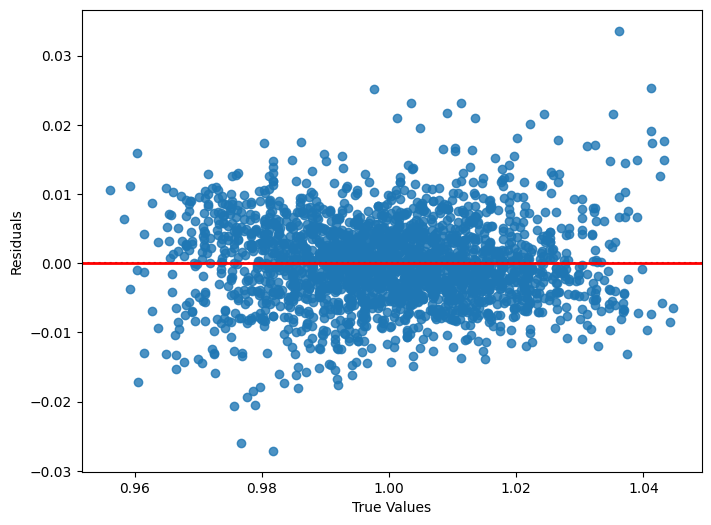

In [37]:
residuals = Y_test - outsample_predictions

plt.figure(figsize=(8, 6))
sns.residplot(x=Y_test, y=residuals, line_kws={"color": "red", "lw": 2})
plt.axhline(0, color='red', linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Residuals")
plt.show()

##### Features Importance

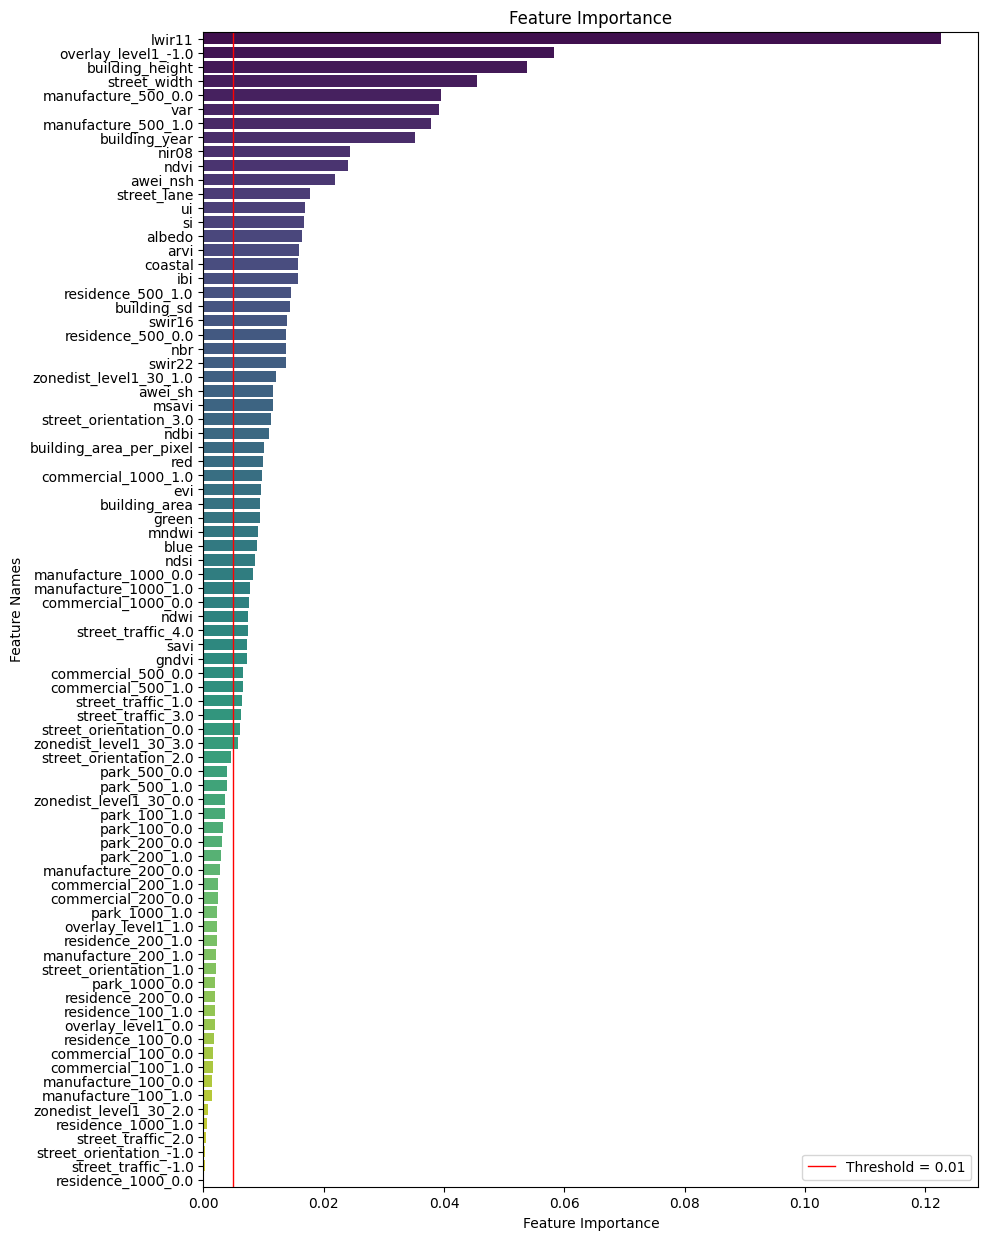

In [38]:
feature_importances = rf.feature_importances_

feature_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_df = feature_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 15))
sns.barplot(x="Importance", y="Feature", data=feature_df, palette="viridis")
plt.axvline(x=0.005, color='red', linestyle='-', linewidth=1, label="Threshold = 0.01")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Feature Importance")
plt.legend()
plt.show()

In [48]:
feature_df[feature_df['Importance'] < 0.01]

Feature  Importance
3                       nir08    0.009161
16            AOD_Uncertainty    0.008299
35                   awei_nsh    0.007947
181  zonedist_level3_30_111.0    0.007776
13                street_lane    0.007538
..                        ...         ...
398  zonedist_level3_500_14.0    0.000000
21        AngstromExp_470-780    0.000000
124   zonedist_level2_30_34.0    0.000000
211   zonedist_level2_100_8.0    0.000000
268  zonedist_level3_100_84.0    0.000000

[460 rows x 2 columns]

#### XGB

In [179]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    min_child_weight=5,
    colsample_bytree=1,
    subsample=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, random_state=42, ...)

##### In-Sample Evaluation

In [180]:
# Make predictions on the training data
insample_predictions = xgb.predict(X_train)

# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

0.9905648827552795

##### Out-Sample Evaluation

In [181]:
# Make predictions on the test data
outsample_predictions = xgb.predict(X_test)

# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

0.8959559202194214

##### Residuals

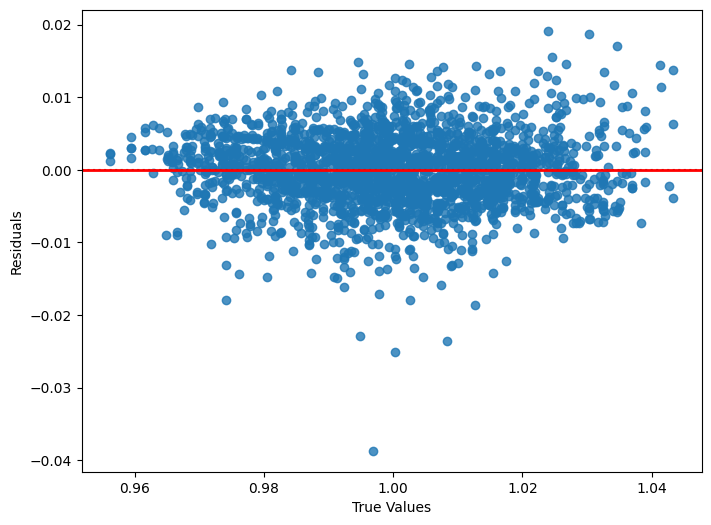

In [182]:
residuals = Y_test - outsample_predictions

plt.figure(figsize=(8, 6))
sns.residplot(x=Y_test, y=residuals, line_kws={"color": "red", "lw": 2})
plt.axhline(0, color='red', linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Residuals")
plt.show()

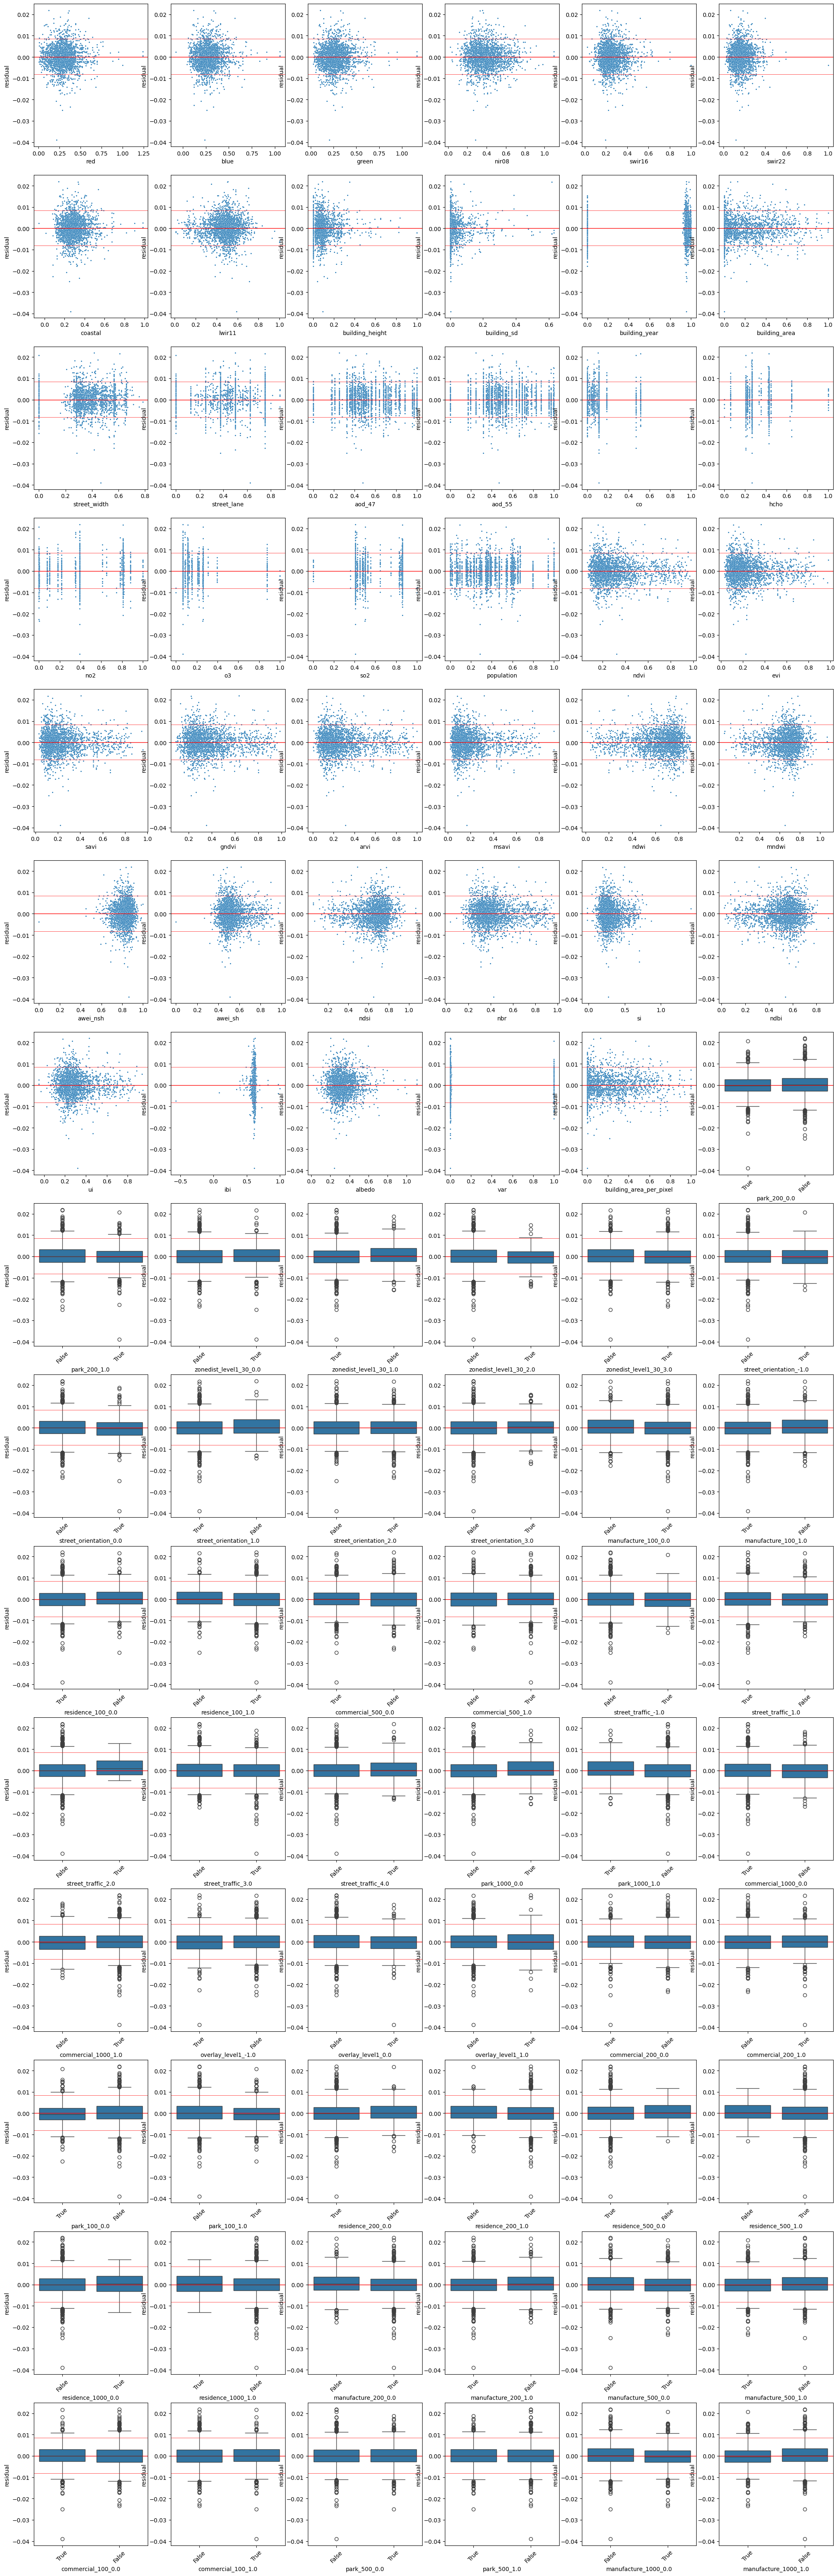

In [184]:
res_plot_df = X_test.copy()
res_plot_df['residual'] = residuals

fig, axes = plt.subplots(15, 6, figsize=(25, 80))
axes = axes.flatten()

# Iterate over all pairs
for i, col in enumerate(X_test.columns):
    ax = axes[i]

    if col in numerical_cols:
        sns.scatterplot(x=col, y="residual", data=res_plot_df, ax=ax, s=5)
    else:
        sns.boxplot(x=res_plot_df[col], y=res_plot_df['residual'], ax=ax)
        ax.set_xticklabels(res_plot_df[col].unique(), rotation=45)

    ax.axhline(0, color='red', linewidth=1)
    ax.axhline(np.percentile(residuals, 95), color='red', linewidth=0.5)
    ax.axhline(np.percentile(residuals, 5), color='red', linewidth=0.5)
    ax.set_xlabel(col)

plt.show()

## Submission

In [185]:
submission_data_path = '../Submission_template_UHI2025-v2.csv' 

In [186]:
#Reading the coordinates for the submission
test_file = pd.read_csv(submission_data_path)
test_file

Longitude   Latitude  UHI Index
0    -73.971665  40.788763        NaN
1    -73.971928  40.788875        NaN
2    -73.967080  40.789080        NaN
3    -73.972550  40.789082        NaN
4    -73.969697  40.787953        NaN
...         ...        ...        ...
1035 -73.919388  40.813803        NaN
1036 -73.931033  40.833178        NaN
1037 -73.934647  40.854542        NaN
1038 -73.917223  40.815413        NaN
1039 -73.911645  40.804402        NaN

[1040 rows x 3 columns]

In [187]:
# # Mapping satellite data for submission.
# val_landsat_data = map_satellite_data(data_dir + 'landsat_8.tiff', submission_data_path, landsat_bands)
# val_building_data = map_satellite_data(data_dir + 'building_res30.tiff', submission_data_path, building_bands)
# val_street_data = map_satellite_data(data_dir + 'street_res30.tiff', submission_data_path, street_bands)
# val_nyco_data = map_satellite_data(data_dir + 'nyco_res30.tiff', submission_data_path, nyco_bands)
# val_nysp_data = map_satellite_data(data_dir + 'nysp_res30.tiff', submission_data_path, nysp_bands)
# val_nyzd30_data = map_satellite_data(data_dir + 'nyzd_res30.tiff', submission_data_path, nyzd30_bands)
# val_nyzd100_data = map_satellite_data(data_dir + 'nyzd_res100.tiff', submission_data_path, nyzd100_bands)
# val_nyzd200_data = map_satellite_data(data_dir + 'nyzd_res200.tiff', submission_data_path, nyzd200_bands)
# val_nyzd500_data = map_satellite_data(data_dir + 'nyzd_res500.tiff', submission_data_path, nyzd500_bands)
# val_nyzd1000_data = map_satellite_data(data_dir + 'nyzd_res1000.tiff', submission_data_path, nyzd1000_bands)

# tif_path = "../data_pipeline/data/tiff/air_quality/AOD/AOD_median_3months.tif"
# val_aod_data = map_satellite_data(csv_path=submission_data_path,
#                               tiff_path=tif_path,
#                               col_name=aod_bands)

# val_co_data = map_satellite_data(csv_path=submission_data_path, tiff_path=aq_path+"co_20210724_165223.tif", col_name=co_bands)
# val_hcho_data = map_satellite_data(csv_path=submission_data_path, tiff_path=aq_path+"hcho_20210724_165223.tif", col_name=hcho_bands)
# val_no2_data = map_satellite_data(csv_path=submission_data_path, tiff_path=aq_path+"no2_20210724_165223.tif", col_name=no2_bands)
# val_o3_data = map_satellite_data(csv_path=submission_data_path, tiff_path=aq_path+"o3_20210724_165223.tif", col_name=o3_bands)
# val_so2_data = map_satellite_data(csv_path=submission_data_path, tiff_path=aq_path+"so2_20210724_165223.tif", col_name=so2_bands)

val_population_data = map_satellite_data(csv_path=submission_data_path, tiff_path="../data_pipeline/data/tiff/population_res1000.tiff", col_name=['population'])

Mapping values:   0%|          | 0/1040 [00:00<?, ?it/s]

Go through layer: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


In [200]:
# val_landsat_data.to_csv("../data_pipeline/data/tabular_data/submission/landsat_res30.csv")
# val_building_data.to_csv("../data_pipeline/data/tabular_data/submission/building_res30.csv")
# val_street_data.to_csv("../data_pipeline/data/tabular_data/submission/street_res30.csv")
# val_nyco_data.to_csv("../data_pipeline/data/tabular_data/submission/nyco_res30.csv")
# val_nysp_data.to_csv("../data_pipeline/data/tabular_data/submission/nysp_res30.csv")
# val_nyzd30_data.to_csv("../data_pipeline/data/tabular_data/submission/nyzd_res30.csv")
# val_nyzd100_data.to_csv("../data_pipeline/data/tabular_data/submission/nyzd_res100.csv")
# val_nyzd200_data.to_csv("../data_pipeline/data/tabular_data/submission/nyzd_res200.csv")
# val_nyzd500_data.to_csv("../data_pipeline/data/tabular_data/submission/nyzd_res500.csv")
# val_nyzd1000_data.to_csv("../data_pipeline/data/tabular_data/submission/nyzd_res1000.csv")

val_aod_data.to_csv("../data_pipeline/data/tabular_data/submission/aod_median_3months.csv")
val_co_data.to_csv("../data_pipeline/data/tabular_data/submission/co_july24.csv")
val_hcho_data.to_csv("../data_pipeline/data/tabular_data/submission/hcho_july24.csv")
val_no2_data.to_csv("../data_pipeline/data/tabular_data/submission/no2_july24.csv")
val_o3_data.to_csv("../data_pipeline/data/tabular_data/submission/o3_july24.csv")
val_so2_data.to_csv("../data_pipeline/data/tabular_data/submission/so2_july24.csv")
val_population_data.to_csv("../data_pipeline/data/tabular_data/submission/population_res1000.csv")



In [188]:
val_data = pd.concat([val_landsat_data, val_building_data, val_street_data, 
                      val_nyco_data, val_nysp_data, val_nyzd30_data, val_nyzd100_data, val_nyzd200_data, val_nyzd500_data, val_nyzd1000_data,
                      val_aod_data, val_co_data, val_hcho_data, val_no2_data, val_o3_data, val_so2_data, val_population_data
                      ]
                      , axis=1)

val_data

red                 blue                green  \
0     0.061580000000000024  0.05170750000000002  0.07354250000000001   
1     0.061580000000000024  0.05170750000000002  0.07354250000000001   
2                   0.1432  0.11163000000000001            0.1309075   
3                0.1856875  0.13085249999999998  0.17215750000000002   
4      0.12166749999999998  0.12287749999999997  0.12205250000000001   
...                    ...                  ...                  ...   
1035               0.14298  0.10453499999999999  0.12425249999999999   
1036              0.133795  0.11179499999999998            0.1463625   
1037   0.15425499999999998  0.10827500000000001  0.14012000000000002   
1038   0.22058500000000003            0.1849175              0.20293   
1039             0.1437775  0.10761500000000002            0.1311275   

                    nir08               swir16               swir22  \
0               0.2785275  0.15694999999999998  0.09744000000000003   
1               0.2785275  0.15694999999999998  0.09744000000000003   
2               0.1695175  0.17394500000000002  0.16019499999999998   
3     0.22102500000000003              0.23373            0.2094475   
4               0.2677475              0.22218  0.16286250000000002   
...                   ...                  ...                  ...   
1035  0.17653000000000002            0.1961925  0.20735750000000003   
1036            0.3164775  0.23606749999999999             0.158325   
1037  0.24288749999999998              0.21019            0.1721025   
1038            0.2938175            0.3075125            0.2813325   
1039            0.1765025            0.1724325  0.14683000000000002   

                  coastal              lwir11 building_height building_sd  \
0               0.0476375  36.202990279999995            62.0         0.0   
1               0.0476375  36.202990279999995            62.0         0.0   
2     0.09994249999999999  36.069687499999986       235.43724         0.0   
3     0.11088750000000003  36.886594280000054           70.91    12.13869   
4     0.12026500000000001   34.50081632000001       52.617714   7.3591685   
...                   ...                 ...             ...         ...   
1035             0.097495  39.754313060000015            33.5         2.5   
1036            0.0987325   34.92806882000002       13.105746         0.0   
1037            0.0924625   38.85537380000005           70.65         0.0   
1038  0.17114000000000001  39.200593819999995          22.355       2.785   
1039  0.09562500000000002  39.409093040000016             0.0        -1.0   

      ... commercial_1000 park_1000  aod_47               aod_55  \
0     ...             1.0       1.0   0.296                0.214   
1     ...             1.0       1.0   0.296                0.214   
2     ...             1.0       1.0    0.31                0.224   
3     ...             1.0       1.0   0.296                0.214   
4     ...             1.0       1.0   0.296                0.214   
...   ...             ...       ...     ...                  ...   
1035  ...             1.0       1.0    0.24  0.17300000000000001   
1036  ...             1.0       1.0  0.2455                0.177   
1037  ...             1.0       1.0   0.224                0.161   
1038  ...             1.0       1.0    0.24  0.17300000000000001   
1039  ...             0.0       1.0  0.2405                0.173   

                        co                    hcho                     no2  \
0     0.047145281211757664  0.00020676884742002247   0.0002539715205786633   
1     0.047145281211757664  0.00020676884742002247   0.0002539715205786633   
2      0.04690194988003092   0.0002067688474197929   0.0002539715205783813   
3     0.047145281211757664  0.00020676884742002247   0.0002539715205786633   
4     0.047145281211757664  0.00020676884742002247   0.0002539715205786633   
...                    ...                     ...                     ...   
1035   0.04744131

In [189]:
val_data = calculate_indices(val_data)
val_data

red                 blue                green  \
0     0.061580000000000024  0.05170750000000002  0.07354250000000001   
1     0.061580000000000024  0.05170750000000002  0.07354250000000001   
2                   0.1432  0.11163000000000001            0.1309075   
3                0.1856875  0.13085249999999998  0.17215750000000002   
4      0.12166749999999998  0.12287749999999997  0.12205250000000001   
...                    ...                  ...                  ...   
1035               0.14298  0.10453499999999999  0.12425249999999999   
1036              0.133795  0.11179499999999998            0.1463625   
1037   0.15425499999999998  0.10827500000000001  0.14012000000000002   
1038   0.22058500000000003            0.1849175              0.20293   
1039             0.1437775  0.10761500000000002            0.1311275   

                    nir08               swir16               swir22  \
0               0.2785275  0.15694999999999998  0.09744000000000003   
1               0.2785275  0.15694999999999998  0.09744000000000003   
2               0.1695175  0.17394500000000002  0.16019499999999998   
3     0.22102500000000003              0.23373            0.2094475   
4               0.2677475              0.22218  0.16286250000000002   
...                   ...                  ...                  ...   
1035  0.17653000000000002            0.1961925  0.20735750000000003   
1036            0.3164775  0.23606749999999999             0.158325   
1037  0.24288749999999998              0.21019            0.1721025   
1038            0.2938175            0.3075125            0.2813325   
1039            0.1765025            0.1724325  0.14683000000000002   

                  coastal              lwir11 building_height building_sd  \
0               0.0476375  36.202990279999995            62.0         0.0   
1               0.0476375  36.202990279999995            62.0         0.0   
2     0.09994249999999999  36.069687499999986       235.43724         0.0   
3     0.11088750000000003  36.886594280000054           70.91    12.13869   
4     0.12026500000000001   34.50081632000001       52.617714   7.3591685   
...                   ...                 ...             ...         ...   
1035             0.097495  39.754313060000015            33.5         2.5   
1036            0.0987325   34.92806882000002       13.105746         0.0   
1037            0.0924625   38.85537380000005           70.65         0.0   
1038  0.17114000000000001  39.200593819999995          22.355       2.785   
1039  0.09562500000000002  39.409093040000016             0.0        -1.0   

      ...   awei_sh      ndsi       nbr        si      ndbi        ui  \
0     ...  0.375349 -0.361866  0.481657  0.504379 -0.279182  0.436416   
1     ...  0.375349 -0.361866  0.481657  0.504379 -0.279182  0.436416   
2     ...  0.025584 -0.141175  0.028275  0.218209  0.012891  0.096943   
3     ...  0.027241 -0.151698  0.026895  0.282179  0.027938  0.114546   
4     ...  0.183138 -0.290872  0.243573  0.287785 -0.093009  0.292317   
...   ...       ...       ...       ...       ...       ...       ...   
1035  ... -0.065881   -0.2245 -0.080303  0.304786  0.052754  0.156889   
1036  ...  0.318019 -0.234566  0.333091  0.357246 -0.145527  0.276515   
1037  ...  0.146831 -0.200023   0.17057  0.320019 -0.072168   0.15348   
1038  ...  0.007977 -0.204886  0.021707  0.248959  0.022775  0.164605   
1039  ...  0.066586 -0.136069  0.091771  0.231452 -0.011664   0.09062   

           ibi    albedo          var building_area_per_pixel  
0     1.200954  0.130571     2.066667                0.244634  
1     1.200954  0.130571     2.066667                0.006563  
2    -1.323438   0.12786  1000.000000                0.462433  
3    -1.855679  0.167434     2.363667                0.199482  
4     0.352694  0.169333     1.644304                0.245835  
...        ...       ...          ...                     ...  
1035 -1.956221  0.133124     0.558333                0.

In [190]:
val_data[numerical_cols] = val_data[numerical_cols].astype('float')

val_data[categorical_cols] = val_data[categorical_cols].astype('float')
val_data[categorical_cols] = val_data[categorical_cols].astype('category')

val_data

red      blue     green     nir08    swir16    swir22   coastal  \
0     0.061580  0.051708  0.073543  0.278527  0.156950  0.097440  0.047637   
1     0.061580  0.051708  0.073543  0.278527  0.156950  0.097440  0.047637   
2     0.143200  0.111630  0.130908  0.169517  0.173945  0.160195  0.099942   
3     0.185688  0.130852  0.172158  0.221025  0.233730  0.209448  0.110888   
4     0.121667  0.122877  0.122053  0.267748  0.222180  0.162863  0.120265   
...        ...       ...       ...       ...       ...       ...       ...   
1035  0.142980  0.104535  0.124252  0.176530  0.196192  0.207358  0.097495   
1036  0.133795  0.111795  0.146363  0.316478  0.236067  0.158325  0.098733   
1037  0.154255  0.108275  0.140120  0.242887  0.210190  0.172102  0.092463   
1038  0.220585  0.184918  0.202930  0.293818  0.307513  0.281332  0.171140   
1039  0.143778  0.107615  0.131128  0.176503  0.172432  0.146830  0.095625   

         lwir11  building_height  building_sd  ...   awei_sh      ndsi  \
0     36.202990        62.000000     0.000000  ...  0.375349 -0.361866   
1     36.202990        62.000000     0.000000  ...  0.375349 -0.361866   
2     36.069687       235.437241     0.000000  ...  0.025584 -0.141175   
3     36.886594        70.910004    12.138690  ...  0.027241 -0.151698   
4     34.500816        52.617714     7.359169  ...  0.183138 -0.290872   
...         ...              ...          ...  ...       ...       ...   
1035  39.754313        33.500000     2.500000  ... -0.065881 -0.224500   
1036  34.928069        13.105746     0.000000  ...  0.318019 -0.234566   
1037  38.855374        70.650002     0.000000  ...  0.146831 -0.200023   
1038  39.200594        22.355000     2.785000  ...  0.007977 -0.204886   
1039  39.409093         0.000000    -1.000000  ...  0.066586 -0.136069   

           nbr        si      ndbi        ui       ibi    albedo          var  \
0     0.481657  0.504379 -0.279182  0.436416  1.200954  0.130571     2.066667   
1     0.481657  0.504379 -0.279182  0.436416  1.200954  0.130571     2.066667   
2     0.028275  0.218209  0.012891  0.096943 -1.323438  0.127860  1000.000000   
3     0.026895  0.282179  0.027938  0.114546 -1.855679  0.167434     2.363667   
4     0.243573  0.287785 -0.093009  0.292317  0.352694  0.169333     1.644304   
...        ...       ...       ...       ...       ...       ...          ...   
1035 -0.080303  0.304786  0.052754  0.156889 -1.956221  0.133124     0.558333   
1036  0.333091  0.357246 -0.145527  0.276515  2.172966  0.185732     0.504067   
1037  0.170570  0.320019 -0.072168  0.153480  0.164002  0.158911     2.207813   
1038  0.021707  0.248959  0.022775  0.164605 -1.617009  0.228834     0.971956   
1039  0.091771  0.231452 -0.011664  0.090620 -0.734577  0.128018     0.000000   

     building_area_per_pixel  
0                   0.244634  
1                   0.006563  
2                   0.462433  
3                   0.199482  
4                   0.245835  
...                      ...  
1035                0.099346  
1036                0.013243  
1037                0.000545  
1038                0.282601  
1039                0.000000  

[1040 rows x 82 columns]

In [191]:
# One-hot encodiing
# encoder = OneHotEncoder(sparse_output=False)
# val_ohe = encoder.fit_transform(val_data[categorical_cols])
val_data = pd.get_dummies(val_data, columns=cat_col_included)
val_data

red      blue     green     nir08    swir16    swir22   coastal  \
0     0.061580  0.051708  0.073543  0.278527  0.156950  0.097440  0.047637   
1     0.061580  0.051708  0.073543  0.278527  0.156950  0.097440  0.047637   
2     0.143200  0.111630  0.130908  0.169517  0.173945  0.160195  0.099942   
3     0.185688  0.130852  0.172158  0.221025  0.233730  0.209448  0.110888   
4     0.121667  0.122877  0.122053  0.267748  0.222180  0.162863  0.120265   
...        ...       ...       ...       ...       ...       ...       ...   
1035  0.142980  0.104535  0.124252  0.176530  0.196192  0.207358  0.097495   
1036  0.133795  0.111795  0.146363  0.316478  0.236067  0.158325  0.098733   
1037  0.154255  0.108275  0.140120  0.242887  0.210190  0.172102  0.092463   
1038  0.220585  0.184918  0.202930  0.293818  0.307513  0.281332  0.171140   
1039  0.143778  0.107615  0.131128  0.176503  0.172432  0.146830  0.095625   

         lwir11  building_height  building_sd  ...  manufacture_200_0.0  \
0     36.202990        62.000000     0.000000  ...                 True   
1     36.202990        62.000000     0.000000  ...                 True   
2     36.069687       235.437241     0.000000  ...                 True   
3     36.886594        70.910004    12.138690  ...                 True   
4     34.500816        52.617714     7.359169  ...                 True   
...         ...              ...          ...  ...                  ...   
1035  39.754313        33.500000     2.500000  ...                 True   
1036  34.928069        13.105746     0.000000  ...                False   
1037  38.855374        70.650002     0.000000  ...                 True   
1038  39.200594        22.355000     2.785000  ...                 True   
1039  39.409093         0.000000    -1.000000  ...                False   

      manufacture_200_1.0  manufacture_500_0.0  manufacture_500_1.0  \
0                   False                 True                False   
1                   False                 True                False   
2                   False                 True                False   
3                   False                 True                False   
4                   False                 True                False   
...                   ...                  ...                  ...   
1035                False                 True                False   
1036                 True                False                 True   
1037                False                 True                False   
1038                False                False                 True   
1039                 True                False                 True   

     commercial_100_0.0 commercial_100_1.0 park_500_0.0 park_500_1.0  \
0                  True              False         True        False   
1                  True              False         True        False   
2                  True              False        False         True   
3                 False               True         True        False   
4                  True              False        False         True   
...                 ...                ...          ...          ...   
1035               True              False         True        False   
1036               True              False        False         True   
1037              False               True        False         True   
1038              False               True         True        False   
1039               True              False         True        False   

     manufacture_1000_0.0 manufacture_1000_1.0  
0                    True                False  
1                    True                False  
2                    True                False  
3                    True                False  
4                    True                False  
...                   ...                  ...  
1035                False                 True  
1036                False                 True  
1037          

In [192]:
# Feature Scaling 
submission_val_data = val_data[numerical_cols]
transformed_submission_data = sc.transform(submission_val_data)
val_data[numerical_cols] = sc.transform(val_data[numerical_cols])

In [193]:
transformed_submission_data = val_data.copy()
transformed_submission_data = transformed_submission_data[X_train.columns]
transformed_submission_data

red      blue     green     nir08    swir16    swir22   coastal  \
0     0.099400  0.130631  0.116600  0.517294  0.177108  0.070268  0.164674   
1     0.099400  0.130631  0.116600  0.517294  0.177108  0.070268  0.164674   
2     0.301883  0.286944  0.267486  0.267104  0.206484  0.155925  0.302470   
3     0.407286  0.337088  0.375986  0.385319  0.309820  0.223152  0.331305   
4     0.248465  0.316284  0.244195  0.492552  0.289856  0.159566  0.356010   
...        ...       ...       ...       ...       ...       ...       ...   
1035  0.301337  0.268436  0.249982  0.283199  0.244938  0.220300  0.296023   
1036  0.278551  0.287374  0.308137  0.604393  0.313861  0.153373  0.299283   
1037  0.329308  0.278192  0.291718  0.435496  0.269132  0.172178  0.282765   
1038  0.493860  0.478121  0.456926  0.552386  0.437351  0.321272  0.490038   
1039  0.303316  0.276471  0.268065  0.283136  0.203869  0.137683  0.291096   

        lwir11  building_height  building_sd  ...  manufacture_200_0.0  \
0     0.429237         0.086713     0.003187  ...                 True   
1     0.429237         0.086713     0.003187  ...                 True   
2     0.422506         0.329283     0.003187  ...                 True   
3     0.463756         0.099175     0.041877  ...                 True   
4     0.343286         0.073591     0.026643  ...                 True   
...        ...              ...          ...  ...                  ...   
1035  0.608561         0.046853     0.011156  ...                 True   
1036  0.364860         0.018330     0.003187  ...                False   
1037  0.563169         0.098811     0.003187  ...                 True   
1038  0.580601         0.031266     0.012064  ...                 True   
1039  0.591129         0.000000     0.000000  ...                False   

      manufacture_200_1.0  manufacture_500_0.0  manufacture_500_1.0  \
0                   False                 True                False   
1                   False                 True                False   
2                   False                 True                False   
3                   False                 True                False   
4                   False                 True                False   
...                   ...                  ...                  ...   
1035                False                 True                False   
1036                 True                False                 True   
1037                False                 True                False   
1038                False                False                 True   
1039                 True                False                 True   

      commercial_100_0.0  commercial_100_1.0  park_500_0.0  park_500_1.0  \
0                   True               False          True         False   
1                   True               False          True         False   
2                   True               False         False          True   
3                  False                True          True         False   
4                   True               False         False          True   
...                  ...                 ...           ...           ...   
1035                True               False          True         False   
1036                True               False         False          True   
1037               False                True         False          True   
1038               False                True          True         False   
1039                True               False          True         False   

      manufacture_1000_0.0  manufacture_1000_1.0  
0                     True                 False  
1                     True                 False  
2                     True                 False  
3                     True                 False  
4                     True                 False  
...                    ...                   ...  
1035                 False                  True  
1036       

In [194]:
#Making predictions
final_predictions = xgb.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [195]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [196]:
#Displaying the sample submission dataframe
submission_df

Longitude   Latitude  UHI Index
0    -73.971665  40.788763   0.964239
1    -73.971928  40.788875   0.963339
2    -73.967080  40.789080   0.964606
3    -73.972550  40.789082   0.961346
4    -73.969697  40.787953   0.958258
...         ...        ...        ...
1035 -73.919388  40.813803   1.032383
1036 -73.931033  40.833178   1.042912
1037 -73.934647  40.854542   1.040557
1038 -73.917223  40.815413   1.038730
1039 -73.911645  40.804402   1.037244

[1040 rows x 3 columns]

In [197]:
#Dumping the predictions into a csv file.
submission_df.to_csv("../submissions/xgb_all_features_zoning_filtered_air_pop_fixed.csv",index = False)

### Upload submission file on platform

In [275]:
df.columns.difference(excluded_cols + excluded_feautures).tolist()

['AOD_QA',
 'AOD_Uncertainty',
 'AngstromExp_470-780',
 'CO_column_number_density',
 'Column_WV',
 'FineModeFraction',
 'Injection_Height',
 'NO2_column_number_density',
 'O3_column_number_density',
 'Optical_Depth_047',
 'Optical_Depth_055',
 'SO2_column_number_density',
 'albedo',
 'arvi',
 'awei_nsh',
 'awei_sh',
 'blue',
 'building_area',
 'building_area_per_pixel',
 'building_height',
 'building_sd',
 'building_year',
 'coastal',
 'commercial_100',
 'commercial_1000',
 'commercial_200',
 'commercial_500',
 'evi',
 'gndvi',
 'green',
 'ibi',
 'lwir11',
 'manufacture_100',
 'manufacture_1000',
 'manufacture_200',
 'manufacture_500',
 'mndwi',
 'msavi',
 'nbr',
 'ndbi',
 'ndsi',
 'ndvi',
 'ndwi',
 'nir08',
 'overlay_level1',
 'park_100',
 'park_1000',
 'park_200',
 'park_500',
 'red',
 'residence_100',
 'residence_1000',
 'residence_200',
 'residence_500',
 'savi',
 'si',
 'street_lane',
 'street_orientation',
 'street_traffic',
 'street_width',
 'swir16',
 'swir22',
 'tropospheric_H